# Instituto Tecnológico y de Estudios Superiores de Monterrey
## Maestría en Inteligencia Artificial Aplicada
### Proyecto Integrador (Gpo 10) - TC5035.10

### **Proyecto: Diseño Acelerado de Fármacos Agonistas de la Hormona GLP-1**

### Avance 5: Modelo final

#### **Docentes:**
- Dra. Grettel Barceló Alonso - Profesor Titular
- Dr. Luis Eduardo Falcón Morales - Profesor Titular
- Dra. Eduviges Ludivina Facundo Flores  – Profesor Tutor

### **Asesores**
- Dr. Juan Arturo Nolazco Flores
- Dr. Carlos Alberto Brizuela Rodríguez

#### **Miembros del equipo:**
- Cesar Ivan Herrera Martinez A01796392  
- Juan Antonio Cruz Acosta A01795375 
- Julio Baltazar Colín A01794476 

# Modelos Finales
Generación de Nuevas secuencias Peptídicas Agonistas de GLP-1 mediante Modelos de Lenguaje y Evaluación In Silico de su Actividad Biológica

## Introducción
En esta quinta etapa se presenta el desarrollo e integración del modelo final para la generación y evaluación de nuevas secuencias peptídicas con potencial actividad agonista del receptor GLP-1. Esta fase consolida los avances obtenidos en etapas anteriores, extendiendo el uso de la inteligencia artificial desde la predicción de actividad biológica hasta la generación de novo de secuencias candidatas mediante modelos de lenguaje profundo y su posterior evaluación con modelos predictivos de aprendizaje automático.
El trabajo comenzó con una exploración computacional de modelos biomoleculares basados en arquitecturas Transformer, como ProtXLNet y PeptideBERT, con el objetivo de capturar patrones estructurales y funcionales de los péptidos. Estas etapas iniciales también permitieron establecer las propiedades críticas para la viabilidad farmacológica —como hemólisis, solubilidad y no adherencia— que servirían como criterios de filtrado para las secuencias generadas.
Posteriormente, se seleccionó ProtGPT2 como núcleo del modelo generativo. Este modelo, una adaptación del lenguaje GPT-2 entrenado específicamente con secuencias proteicas, fue elegido por su capacidad superior para generar secuencias completas, coherentes y biológicamente plausibles. En comparación con ProtXLNet, ProtGPT2 mostró una mayor diversidad y variabilidad estructural, superando la naturaleza más conservadora de los modelos previos.
Para la evaluación de la coherencia y capacidad predictiva del modelo generativo, se evaluaron las secuencias generadas por los modelos en cuando a su potencia, solubilidad y hemolisis. Esto permitió cuantificar la capacidad del modelo para predecir la disposición de los aminoácidos y, con ello, estimar la calidad de las secuencias generadas.
Las secuencias obtenidas fueron analizadas mediante un modelo predictivo de clasificación basado en un ensemble de Random Forest, desarrollado en fases anteriores del proyecto. Este modelo, entrenado con datos experimentales de péptidos agonistas y no agonistas de GLP-1, fue empleado como herramienta principal para estimar in silico la posible actividad biológica de las secuencias propuestas por ProtGPT2.
Finalmente, se aplicó este mismo modelo predictivo a un conjunto externo de secuencias obtenido de las bases de datos de Google AlphaFold, con el propósito de identificar nuevos candidatos con potencial actividad agonista del receptor GLP-1. Este análisis complementario amplió el espectro de secuencias disponibles y fortaleció la estrategia de diseño racional de péptidos terapéuticos.


## Evaluacion de las seccuencias cononocidas de Alpha Fold con el modelo predictivo

A fin de detectar posibles nuevas secuencias agonistas de GLP-1, se evaluó un conjunto de secuencias obtenidas de la base de datos de Google Alpha Fold utilizando el modelo predictivo basado en Random Forest desarrollado previamente. Este conjunto de secuencias contenía una amplia variedad de péptidos, algunos de los cuales podrían tener actividad biológica relevante. El modelo predictivo se aplicó a cada una de las secuencias del conjunto, y se analizaron los resultados para identificar aquellas secuencias que fueron clasificadas como agonistas de GLP-1.

## Carga de los datos base para uso de los modelos

Para esta evaluación, se emplearan todos los datos procesados con anterioridad, incluyendo el conjunto de 125 péptidos con actividad EC50 conocida, el conjunto de entrenamiento de 224 péptidos de alta diversidad y el conjunto de secuencias similares al GLP-1 obtenidas de las bases de datos de Alpha Fold y UniProt. Con estos datos se procederá a evaluar el desempeño del modelo predictivo y a identificar posibles nuevas secuencias agonistas de GLP-1. en los datos ya conocidos de alfa fold. Posteriormente se procederá a la generación de nuevas secuencias mediante ProtGPT2 y su evaluación con el modelo predictivo.

In [1]:
# Carga de bibliotecas
import os
import sys
import torch
import numpy as np
import pandas as pd
from pathlib import Path
# iFeature cambia la configuración de matplotlib, por lo que se debe volver a activar
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# ruta del directorio del notebook actual
notebook_dir = Path.cwd()
directorio_base = Path.cwd().parent
sys.path.append(str(directorio_base))

from src.plotting import plot_pca_3d, clasificar_y_graficar_cuantiles


In [2]:
# Establecer la ruta los archivos de datos

directorio_datos = Path(directorio_base / "data")
directorio_modelos = Path(directorio_base / "models")
directorio_modelos_automl= Path(directorio_modelos / "pycaret")
raw_data_dir = directorio_datos / "raw"
processed_data_dir = directorio_datos / "processed"

#ruta a los modelos automl
ruta_mejor_modelo_final = directorio_modelos_automl / "modelos_GLP1_no_pca" /"mejor_modelo_final"
# Ruta modelos generativos
ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet_finetuned"

# Datos con actividad conocida
ruta_125_ec50 = processed_data_dir / "descriptores_125.csv"

# Datos con actividad predicha
ruta_predicciones_glp1 = processed_data_dir / "predicciones_glp1.csv"

# Datos sin actividad conocida
ruta_peptidos_eval = processed_data_dir / "descriptores_cdhit.csv"

#Datos de identificacion de secuencias con especie
ruta_glucagon_like_peptides = processed_data_dir / "glucagon_like_peptides.csv"

# directorio para nuevas secuencias 
directorio_nuevas_secuencias = Path(processed_data_dir/"Actividad_5"/"secuencias_nuevas")
os.makedirs(directorio_nuevas_secuencias, exist_ok=True)

# directorio modelos peptide Bert
directorio_modelos_peptidebert = directorio_modelos / "peptideBert"


# directorio temporal
directorio_temporal = Path(directorio_base / "temp")
os.makedirs(directorio_temporal, exist_ok=True)


### Acondicionamiento de los datos de alpha fold para su uso en los modelos
Los datos de secuencias similares al GLP-1 obtenidos de las bases de datos de Alpha Fold y UniProt se cargaron y acondicionaron para su uso en los modelos predictivos. Este proceso incluyó la limpieza de los datos, la eliminación de secuencias duplicadas y la normalización de las secuencias para asegurar su compatibilidad con el modelo. Una vez acondicionados, estos datos se integraron con los conjuntos de datos existentes para su evaluación y análisis posterior. En este caso se eliminaran las columnas que no son necesarias para la evaluación del modelo predictivo, como las columnas relacionadas con la estructura de la consulta en la base de datos, y se mantendrán únicamente las columnas relevantes para la secuencia y su identificación.


In [3]:
# Cargar datos procesados con anterioridad

# datos con actividad Biologica EC 50 conocida
df_125_conocidos = pd.read_csv(ruta_125_ec50)
df_125_conocidos.columns = df_125_conocidos.columns.str.replace('.', '_', regex=False)
df_125_conocidos['-1pEC50'] = -np.log10(df_125_conocidos["EC50_T2"] * 1e-12)

# datos con alta diversidad usados para entrenamiento de los modelos generativos
df_glp1 = pd.read_csv(ruta_peptidos_eval)
df_glp1.columns = df_glp1.columns.str.replace('.', '_', regex=False)

# conjunto de datos de secuencias similares al GLP-1 humano procedentes de Alphafold y  UniProt
df_glucagon_like_peptides = pd.read_csv(ruta_glucagon_like_peptides)
df_glucagon_like_peptides['ID'] = df_glucagon_like_peptides['ID'].str.replace("|", "-")
df_glucagon_like_peptides = df_glucagon_like_peptides[ ["ID", "Description", "GLP-1_Activo", "Species", "organismCommonNames"]].rename(columns={'GLP-1_Activo': 'sequence'})

In [4]:
# visualizar los con 125 péptidos con actividad ec 50 conocida
df_125_conocidos.info()
display(df_125_conocidos.head() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Columns: 1295 entries, ID to -1pEC50
dtypes: float64(1293), object(2)
memory usage: 1.2+ MB


ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  seq_pep1  0.033333    0.0  0.100000  0.100000  0.066667  0.066667   
1  seq_pep2  0.033333    0.0  0.100000  0.100000  0.066667  0.066667   
2  seq_pep3  0.034483    0.0  0.103448  0.068966  0.068966  0.034483   
3  seq_pep4  0.055556    0.0  0.083333  0.027778  0.055556  0.166667   
4  seq_pep5  0.066667    0.0  0.100000  0.066667  0.066667  0.066667   

      AAC_H  AAC_I     AAC_K  ...  NMBroto_BEGF750103_lag1  \
0  0.033333    0.0  0.033333  ...                -0.027980   
1  0.033333    0.0  0.033333  ...                 0.000910   
2  0.034483    0.0  0.034483  ...                -0.004817   
3  0.027778    0.0  0.027778  ...                 0.225090   
4  0.033333    0.0  0.033333  ...                 0.088858   

   NMBroto_BEGF750103_lag2  NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
0                -0.182783                 0.054222                 0.190428   
1                -0.316149                 0.170202                 0.157133   
2                -0.250582                 0.181550                 0.098041   
3                -0.097965                 0.052838                 0.377701   
4                -0.190213                 0.020097                 0.069381   

   NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
0                -0.142437                 0.090372   
1                -0.144228                 0.115217   
2                -0.203722                 0.127012   
3                 0.150231                 0.286987   
4                -0.184796                 0.222087   

                               sequence  EC50_T2  EC50_LOG_T2    -1pEC50  
0        HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE   563.00        -9.25   9.249492  
1        HSQGTFTSDYSKYLDSRRAEDFVQWLENGE   552.00        -9.26   9.258061  
2         HSQGTFTSDYSKYLDSRRAEDFVQWLENT   252.00        -9.60   9.598599  
3  HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG     6.03       -11.22  11.219683  
4        HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG   238.00        -9.62   9.623423  

[5 rows x 1295 columns]

In [5]:
# visualizar los datos entrenamiento, 224 péptidos de alta diversidad

df_glp1.info()
display(df_glp1.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225 entries, 0 to 224
Columns: 1292 entries, ID to sequence
dtypes: float64(1290), object(2)
memory usage: 2.2+ MB


ID     AAC_A  AAC_C     AAC_D     AAC_E     AAC_F     AAC_G  \
0  AF-A0A060VXS0-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
1  AF-A0A060VY52-F1  0.100000    0.0  0.066667  0.066667  0.033333  0.066667   
2  AF-A0A060WDT4-F1  0.100000    0.0  0.133333  0.000000  0.033333  0.066667   
3  AF-A0A087VEU7-F1  0.133333    0.0  0.033333  0.100000  0.033333  0.100000   
4  AF-A0A087XPV4-F1  0.100000    0.0  0.133333  0.000000  0.066667  0.066667   

      AAC_H     AAC_I     AAC_K  ...  NMBroto_BEGF750102_lag1  \
0  0.033333  0.000000  0.066667  ...                 0.037142   
1  0.033333  0.000000  0.066667  ...                 0.037142   
2  0.033333  0.000000  0.066667  ...                -0.029432   
3  0.033333  0.066667  0.033333  ...                 0.068401   
4  0.033333  0.033333  0.100000  ...                 0.094549   

   NMBroto_BEGF750102_lag2  NMBroto_BEGF750102_lag3  NMBroto_BEGF750103_lag1  \
0                -0.508484                 0.112768                 0.224928   
1                -0.508484                 0.112768                 0.145803   
2                -0.341003                 0.010969                -0.055908   
3                -0.469261                -0.028003                 0.179833   
4                -0.460741                 0.040947                 0.156853   

   NMBroto_BEGF750103_lag2  NMBroto_BEGF750103_lag3  NMBroto_BHAR880101_lag1  \
0                -0.142711                 0.120597                 0.099330   
1                -0.195554                 0.086696                 0.178218   
2                -0.413757                -0.005239                 0.086834   
3                -0.232789                 0.257321                 0.296206   
4                -0.296064                -0.234672                 0.149114   

   NMBroto_BHAR880101_lag2  NMBroto_BHAR880101_lag3  \
0                -0.372417                 0.041586   
1                -0.292699                 0.046946   
2                -0.334601                -0.073197   
3                -0.151547                -0.086574   
4                -0.209235                -0.250359   

                         sequence  
0  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR  
1  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR  
2  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL  
3  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR  
4  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ  

[5 rows x 1292 columns]

In [6]:
# Visualizacion de los peptidos similares al GLP-1 procedentes de Aphafold DB y UniProt
df_glucagon_like_peptides.info()
display(df_glucagon_like_peptides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   897 non-null    object
 1   Description          897 non-null    object
 2   sequence             897 non-null    object
 3   Species              798 non-null    object
 4   organismCommonNames  408 non-null    object
dtypes: object(5)
memory usage: 35.2+ KB


ID  \
0                  AF-A0A060VXS0-F1   
1                  AF-A0A060VY52-F1   
2                  AF-A0A060WDT4-F1   
3                  AF-A0A087VEU7-F1   
4                  AF-A0A087XPV4-F1   
..                              ...   
892  tr-A0A8C9ICK2-A0A8C9ICK2_9PRIM   
893  tr-A0A8I3QXE0-A0A8I3QXE0_CANLF   
894          tr-F7ID40-F7ID40_CALJA   
895          tr-G1TRR9-G1TRR9_RABIT   
896          tr-G3QHC4-G3QHC4_GORGO   

                                           Description  \
0                              Uncharacterized protein   
1                              Uncharacterized protein   
2                   GLUCAGON domain-containing protein   
3                                             Glucagon   
4                                             Glucagon   
..                                                 ...   
892  tr|A0A8C9ICK2|A0A8C9ICK2_9PRIM Glucagon OS=Pil...   
893                                           Glucagon   
894                                           Glucagon   
895                                           Glucagon   
896                                           Glucagon   

                           sequence  \
0    HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR   
1    HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR   
2    HADGTYTSDVSTYLQDQAAKDFVSWLKSGL   
3    HAEGTYTSDITSYLEGQAAKEFIAWLVNGR   
4    HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ   
..                              ...   
892  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   
893  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   
894  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   
895  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   
896  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   

                                               Species  \
0                                  Oncorhynchus mykiss   
1                                  Oncorhynchus mykiss   
2                                  Oncorhynchus mykiss   
3    Balearica regulorum gibbericeps (East African ...   
4                                     Poecilia formosa   
..                                                 ...   
892                                                NaN   
893                             Canis lupus familiaris   
894                                 Callithrix jacchus   
895                              Oryctolagus cuniculus   
896                            Gorilla gorilla gorilla   

           organismCommonNames  
0                          NaN  
1                          NaN  
2                Rainbow trout  
3                          NaN  
4                 Amazon molly  
..                         ...  
892                        NaN  
893                        Dog  
894  White-tufted-ear marmoset  
895                     Rabbit  
896    Western lowland gorilla  

[897 rows x 5 columns]

## Predicción de la actividad Biologica del conjunto de secuencias

### Cálculo de las características necesarias para la predicción de la actividad biológica 

Se calculan las características necesarias para la predicción de la actividad biológica de las secuencias peptídicas utilizando la herramienta iFeature omega. Usando el mismo conjunto de características que se emplearon para entrenar el modelo predictivo

In [7]:
# cargar las configuraciones de iFeature Omega
from src.ifeature_process import calcular_descriptores_ifeature
ifeatures_settings_json = Path(directorio_datos / 
                               "iFeature Settings" / 
                               "Protein_parameters_setting.json") 
ifeatures_settings_json
# Definimos la lista de descriptores a calcular
descriptores = [
            "AAC",				# Amino acid composition
            "CKSAAGP type 1",	# Composition of k-spaced amino acid group pairs type 1- normalized
            "DPC type 1",		# Dipeptide composition type 1 - normalized
            "CTDC",				# Composition
            "CTDT",				# Transition
            "CTDD",				# Distribution
            "CTriad",			# Conjoint triad
            "GAAC",				# Grouped amino acid composition
            "Moran",			# Moran
            "SOCNumber",		# Sequence-order-coupling number
            "QSOrder",			# Quasi-sequence-order descriptors
            "PAAC",				# Pseudo-amino acid composition
            "APAAC",			# Amphiphilic PAAC
            "NMBroto",			# Auto-cross covariance
        ]

In [8]:
# Cálculo de descriptores iFeature Omega para las secuencias similares al GLP-1 humano procedentes de Alpha Fold y UniProt
df_glucagon_like_peptides = calcular_descriptores_ifeature(
        directorio_temporal=directorio_temporal,
        dataframe=df_glucagon_like_peptides,
        sequence_col='sequence',
        id_col='ID',
        descriptores=descriptores,
        ifeatures_settings_json=ifeatures_settings_json
    )

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_223532.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_223532.fasta...
  - OK! File is structurally valid. Found 897 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_223532.fasta' es válido. Se encontraron 897 registros.
Iniciando cálculo de 14 descriptores...


calculando descriptores:   0%|          | 0/14 [00:00<?, ?it/s]

File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
Cálculo de descriptores finalizado.
Descriptores unidos al DataFrame. Forma final: (897, 1295)
Archivo temporal 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_223532.fasta' eliminado.


### Predicción de actividad pEC50 para los péptidos GLP-1

Para la predicción de la actividad pEC50 para todo el conjunto de péptidos similares a GLP-1 con el fin de actualizar los datos utilizando el mejor modelo previamente entrenado.

Este modelo corresponde a un blending de algoritmos de regresión (Random Forest, XGBoost y LightGBM), entrenados a partir de descriptores moleculares derivados de las secuencias peptídicas.

Sus mejores hiperparámetros y desempeño fueron reportados en el Avance 3, donde se obtuvieron los siguientes resultados:

| desc | MAE | MSE | RMSE | R2 | RMSLE | MAPE |
|---|---|---|---|---|---|---|
| **Mean** | **0.6334** | **0.7794** | **0.8146** | **0.6437** | **0.0779** | **0.0689** |
| **Std** | **0.2570** | **0.7524** | **0.3402** | **0.3101** | **0.0337** | **0.0319** |

In [9]:
# cargar el modelo guardado para predicciones con PyCaret
from src.PeptideBert_predict import predict_peptidebert
from pycaret.regression import load_model, predict_model
modelo_pycaret = load_model(ruta_mejor_modelo_final)
modelo_pycaret

Transformation Pipeline and Model Successfully Loaded


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['AAC_A', 'AAC_C', 'AAC_D', 'AAC_E',
                                             'AAC_F', 'AAC_G', 'AAC_H', 'AAC_I',
                                             'AAC_K', 'AAC_L', 'AAC_M', 'AAC_N',
                                             'AAC_P', 'AAC_Q', 'AAC_R', 'AAC_S',
                                             'AAC_T', 'AAC_V', 'AAC_W', 'AAC_Y',
                                             'CKSAAGP_alphaticr_alphaticr_gap0',
                                             'CKSAAGP_alphaticr_aromatic_gap0',
                                             'CKSAAGP_alphaticr_postivec...
                                              ExtraTreesRegressor(criterion='absolute_error',
                                                                  max_depth=5,
                                                                  max_features=0.567711756337121,
                                                                  min_impurity_decrease=0.005297055476899181,
                                                                  min_samples_leaf=2,
                                                                  n_estimators=155,
                                                                  n_jobs=-1,
                                                                  random_state=132400)),
                                             ('Huber Regressor',
                                              HuberRegressor(alpha=0.987530237988201,
                                                             epsilon=1.5704959650312693))],
                                 n_jobs=-1,
                                 weights=[0.33891719768937995,
                                          0.1387358959195408,
                                          0.17830429140572182]))])

## Cálculo de las propiedades de solubilidad, Hemólisis y Nonfouling con PeptideBert

PeptideBert es un modelo de aprendizaje profundo diseñado para predecir propiedades de hemólisis, solubilidad y no adherencia/fouling sobre secuencias de proteínas.

Para cada una de las nuevas secuencias generadas, se calcularon las siguientes propiedades:

* Hemólisis: se refiere a la capacidad del péptido para causar la ruptura de eritrocitos, lo que representa un indicador clave de toxicidad.

* Solubilidad: mide la facilidad con la que el péptido puede disolverse en medios acuosos, aspecto importante para su formulación y biodisponibilidad como medicamento.

* Fouling (o bioincrustación): corresponde a la tendencia del péptido a adherirse a superficies biológicas o sintéticas, generando agregados no deseados o interacciones que limiten su eficacia funcional.

#### Cálculo de Propiedades sobre los datos de alpha fold y uniprot
 

In [10]:
# Cálculo de pEC50 sobre los datos de alpha fold y uniprot
df_glucagon_like_peptides = predict_model(modelo_pycaret, data=df_glucagon_like_peptides)
df_glucagon_like_peptides.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_glucagon_like_peptides = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_glucagon_like_peptides, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)
df_glucagon_like_peptides[["ID","sequence","sol","hemo", "nf", "prediccion_-1pEC50"]].head()

Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/897 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/897 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/897 [00:00<?, ?it/s]

ID                        sequence       sol      hemo  \
0  AF-A0A060VXS0-F1  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR  0.813716  0.051502   
1  AF-A0A060VY52-F1  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR  0.844703  0.054030   
2  AF-A0A060WDT4-F1  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL  0.796401  0.068710   
3  AF-A0A087VEU7-F1  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR  0.730178  0.066916   
4  AF-A0A087XPV4-F1  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ  0.807739  0.059716   

         nf  prediccion_-1pEC50  
0  0.023509            8.729368  
1  0.020588            8.988079  
2  0.016539            9.318927  
3  0.009954            9.398033  
4  0.020352            9.803035

#### Cálculo de propiedades sobre los datos de alta diversidad usados para entrenar los modelos generativos

In [11]:
# Calculo de pEC50 sobre los datos de alta diversidad usados para entrenar los modelos generativos
df_glp1 = predict_model(modelo_pycaret, data=df_glp1)
df_glp1.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto de alta diversidad
df_glp1 = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_glp1, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)
df_glp1[["ID","sequence","prediccion_-1pEC50"]].head()

Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/225 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/225 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/225 [00:00<?, ?it/s]

ID                        sequence  prediccion_-1pEC50
0  AF-A0A060VXS0-F1  HAEGTYTSDMSSYLQDQAAKEFVSWLKNGR            8.729368
1  AF-A0A060VY52-F1  HAEGTYTSDVSSYLQDQAAKEFVSWLKNGR            8.988079
2  AF-A0A060WDT4-F1  HADGTYTSDVSTYLQDQAAKDFVSWLKSGL            9.318927
3  AF-A0A087VEU7-F1  HAEGTYTSDITSYLEGQAAKEFIAWLVNGR            9.398033
4  AF-A0A087XPV4-F1  HADGTFTSDVSSYLKDQAIKDFVAQLKSGQ            9.803035

#### Cálculo de propiedades sobre los datos con actividad conocida usados para entrenar el modelo predictivo

In [12]:
# Calculo de pEC50 sobre los datos con actividad conocida usados para entrenar el modelo predictivo
df_125_conocidos = predict_model(modelo_pycaret, data=df_125_conocidos)
df_125_conocidos.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para los 125 péptidos similares con actividad ec50 conocida
df_125_conocidos = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_125_conocidos, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)
df_125_conocidos[["ID","sequence","sol","hemo", "nf","-1pEC50","prediccion_-1pEC50"]].head()

Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/125 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/125 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/125 [00:00<?, ?it/s]

ID                              sequence       sol      hemo  \
0  seq_pep1        HSQGTFTSDYSKYLDSRRAQDFVQWLEEGE  0.849804  0.055827   
1  seq_pep2        HSQGTFTSDYSKYLDSRRAEDFVQWLENGE  0.845523  0.052318   
2  seq_pep3         HSQGTFTSDYSKYLDSRRAEDFVQWLENT  0.786436  0.052129   
3  seq_pep4  HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG  0.843368  0.055343   
4  seq_pep5        HSQGTFTSDYSKYLDSRRAQDFVQWLEAEG  0.811992  0.056414   

         nf    -1pEC50  prediccion_-1pEC50  
0  0.034196   9.249492            9.256478  
1  0.031188   9.258060            9.328444  
2  0.027671   9.598599            9.321180  
3  0.028107  11.219683           11.209304  
4  0.027693   9.623423            9.573532

In [13]:
# obtener los resultados del pro-glucagon Humano como referencia
df_pro_glucagon_humano = df_glucagon_like_peptides[df_glucagon_like_peptides['ID'].str.contains("human", case=False, na=False)]
df_pro_glucagon_humano[["ID","Description","sequence","sol","hemo", "nf","Species", "prediccion_-1pEC50"]]

ID Description                        sequence  \
875  sp-P01275-GLUC_HUMAN    Glucagon  HAEGTFTSDVSSYLEGQAAKEFIAWLVKGR   

          sol      hemo        nf          Species  prediccion_-1pEC50  
875  0.825296  0.066893  0.009175  Pan troglodytes           10.234846

## Graficos sobre las Propiedades predichas 

### Conjunto de 125 Péptidos con actividad EC50

In [14]:
from src.plotting import clasificar_y_graficar_cuantiles

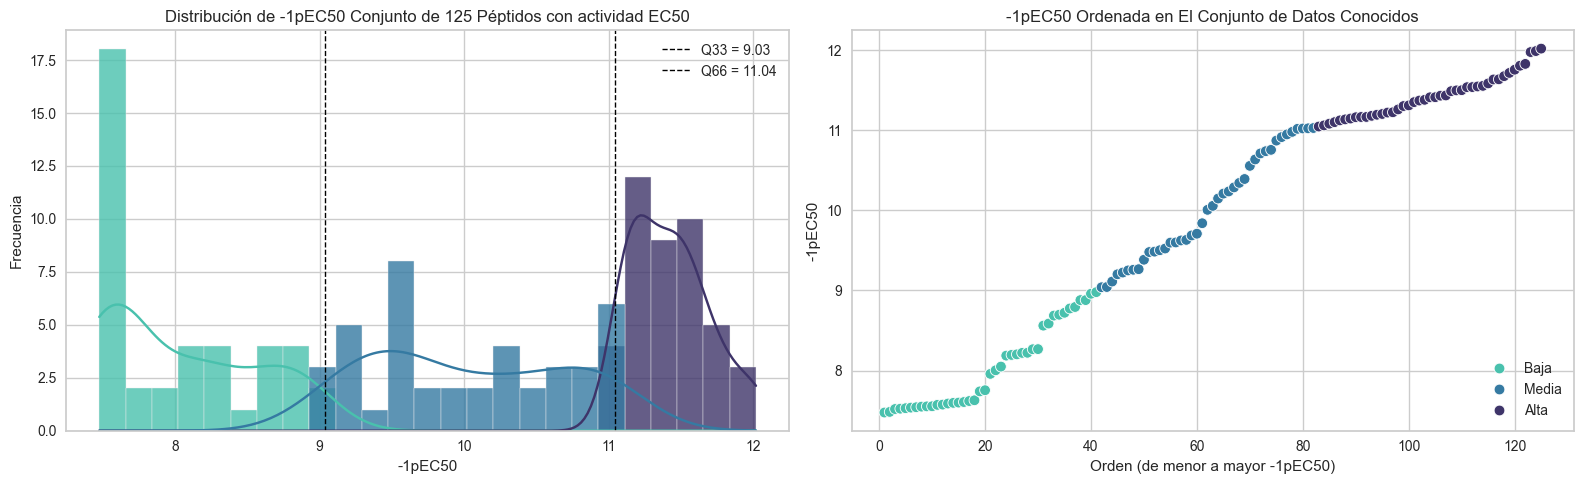


Resumen por categoría:
           n   promedio        min        max
Potencia                                     
Alta      43  11.421007  11.045275  12.017729
Baja      41   8.040037   7.476254   8.978810
Media     41  10.031697   9.039529  11.026872

Top 15 registros de categoría "Alta":


ID    -1pEC50 Potencia
116  seq_pep117  12.017729     Alta
25    seq_pep26  11.987163     Alta
6      seq_pep7  11.974694     Alta
10    seq_pep11  11.826814     Alta
92    seq_pep93  11.804100     Alta
57    seq_pep58  11.754487     Alta
26    seq_pep27  11.714442     Alta
114  seq_pep115  11.673664     Alta
55    seq_pep56  11.634512     Alta
9     seq_pep10  11.632644     Alta
117  seq_pep118  11.583360     Alta
84    seq_pep85  11.552842     Alta
63    seq_pep64  11.545156     Alta
42    seq_pep43  11.537602     Alta
78    seq_pep79  11.536107     Alta

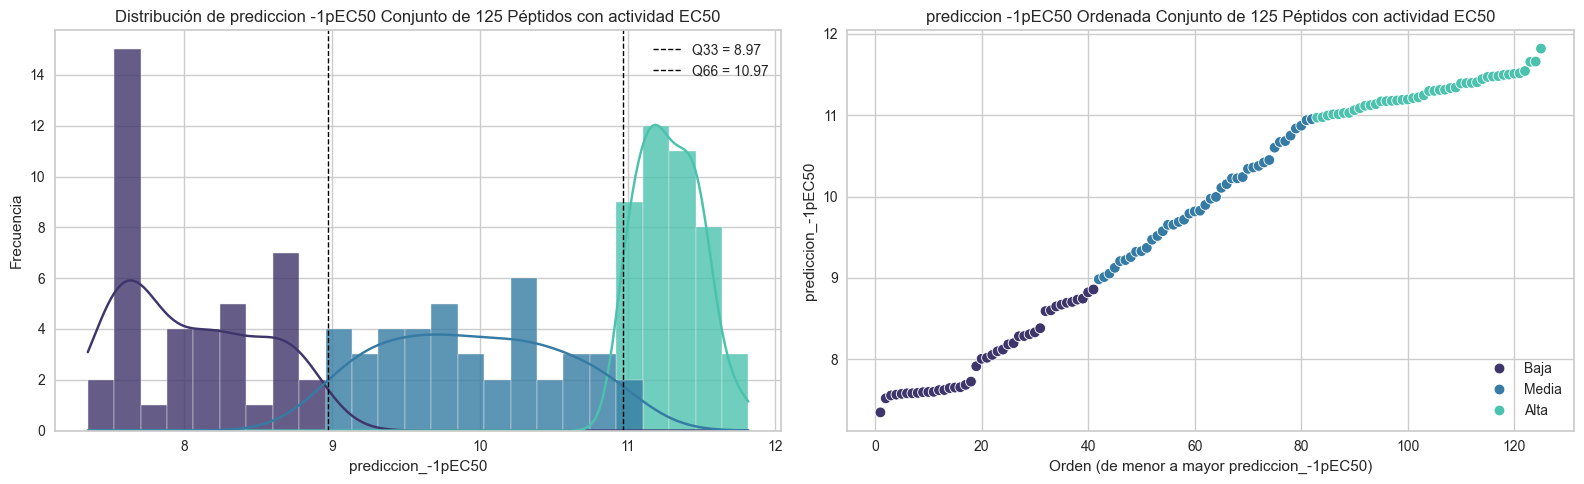


Resumen por categoría:
           n   promedio        min        max
Potencia                                     
Alta      43  11.286066  10.969144  11.817376
Baja      41   8.048172   7.347677   8.857814
Media     41   9.941857   8.983180  10.951030

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
25    seq_pep26           11.817376     Alta
92    seq_pep93           11.658273     Alta
26    seq_pep27           11.655141     Alta
114  seq_pep115           11.541818     Alta
84    seq_pep85           11.514208     Alta
78    seq_pep79           11.509195     Alta
63    seq_pep64           11.498834     Alta
117  seq_pep118           11.493921     Alta
83    seq_pep84           11.479786     Alta
59    seq_pep60           11.474344     Alta
55    seq_pep56           11.469292     Alta
81    seq_pep82           11.442431     Alta
65    seq_pep66           11.403568     Alta
82    seq_pep83           11.395712     Alta
68    seq_pep69           11.393385     Alta

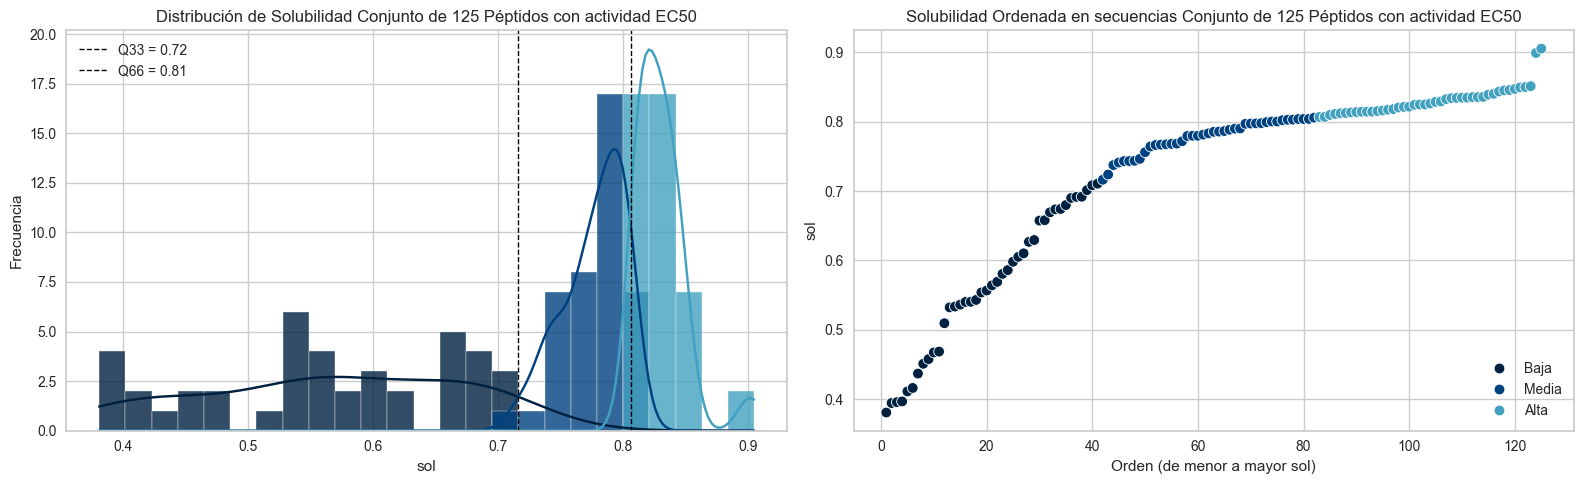


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      43  0.830344  0.806707  0.905196
Baja      41  0.563361  0.380827  0.710580
Media     41  0.777207  0.716259  0.805688

Top 15 registros de categoría "Alta":


ID       sol Potencia
46    seq_pep47  0.905196     Alta
47    seq_pep48  0.898952     Alta
110  seq_pep111  0.851075     Alta
0      seq_pep1  0.849804     Alta
12    seq_pep13  0.849240     Alta
10    seq_pep11  0.847004     Alta
1      seq_pep2  0.845523     Alta
52    seq_pep53  0.844946     Alta
3      seq_pep4  0.843368     Alta
11    seq_pep12  0.840037     Alta
122  seq_pep123  0.838866     Alta
9     seq_pep10  0.835602     Alta
87    seq_pep88  0.835365     Alta
113  seq_pep114  0.835304     Alta
81    seq_pep82  0.834569     Alta

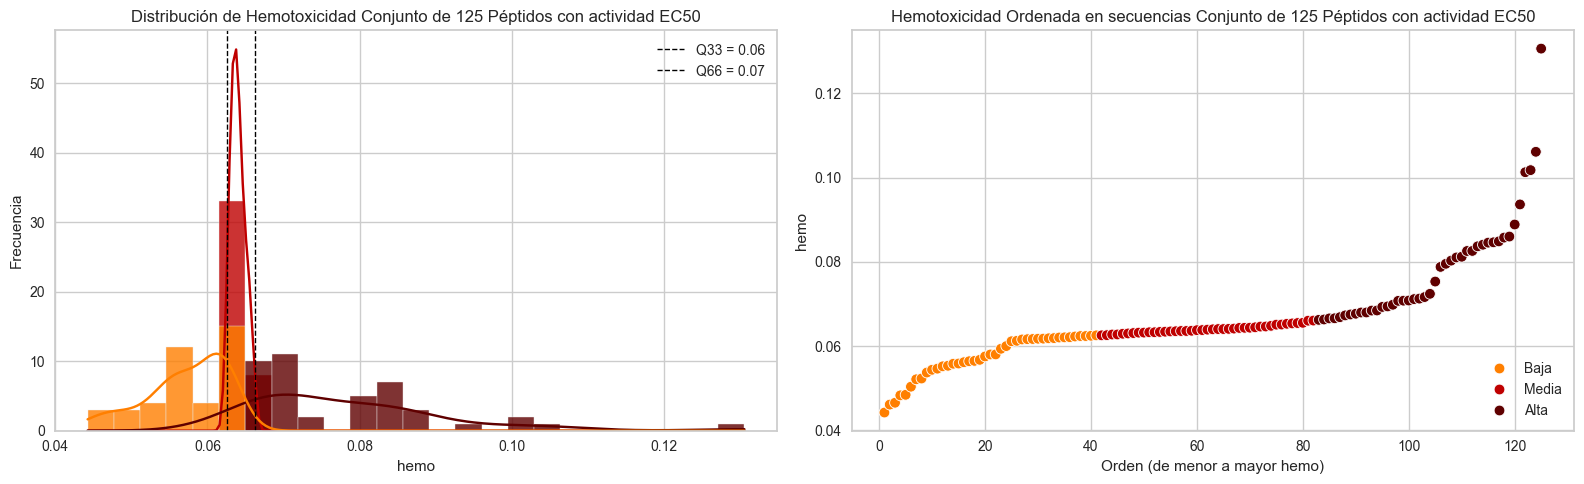


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      43  0.078426  0.066235  0.130579
Baja      41  0.057206  0.044251  0.062554
Media     41  0.064023  0.062560  0.066066

Top 15 registros de categoría "Alta":


ID      hemo Potencia
45    seq_pep46  0.130579     Alta
6      seq_pep7  0.106102     Alta
46    seq_pep47  0.101750     Alta
8      seq_pep9  0.101251     Alta
7      seq_pep8  0.093613     Alta
119  seq_pep120  0.088852     Alta
17    seq_pep18  0.085996     Alta
16    seq_pep17  0.085746     Alta
22    seq_pep23  0.084847     Alta
123  seq_pep124  0.084626     Alta
21    seq_pep22  0.084552     Alta
15    seq_pep16  0.084058     Alta
20    seq_pep21  0.083676     Alta
13    seq_pep14  0.082585     Alta
18    seq_pep19  0.082567     Alta

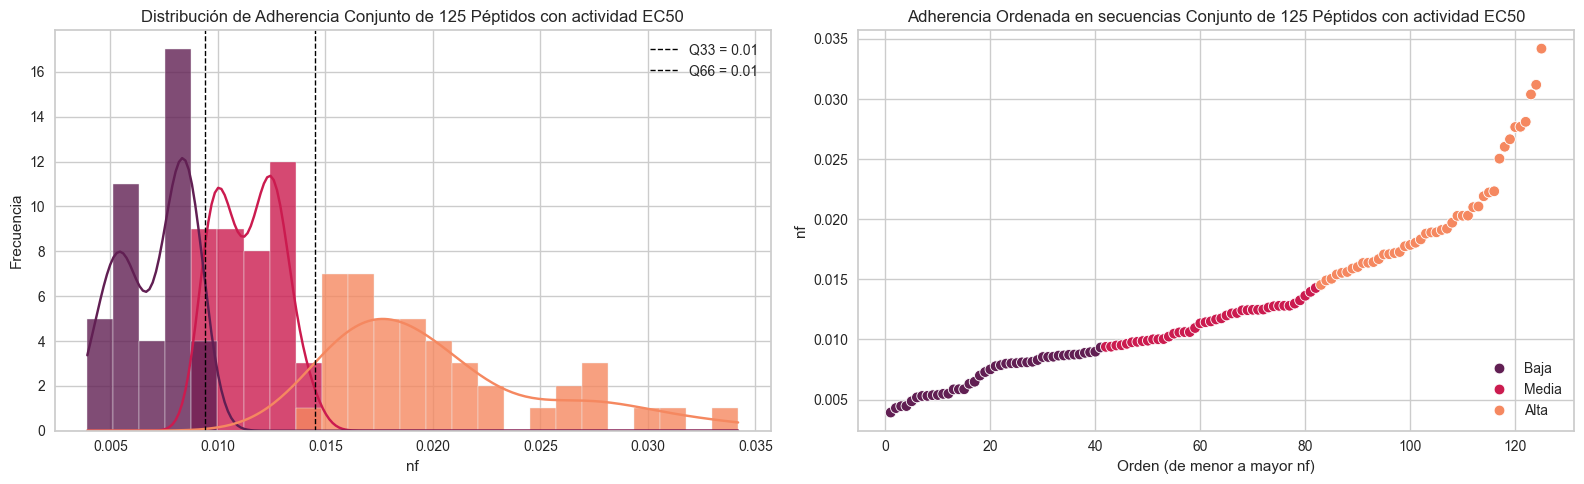


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      43  0.020245  0.014541  0.034196
Baja      41  0.007055  0.003922  0.009333
Media     41  0.011430  0.009386  0.014283

Top 15 registros de categoría "Alta":


ID        nf Potencia
0      seq_pep1  0.034196     Alta
1      seq_pep2  0.031188     Alta
86    seq_pep87  0.030385     Alta
3      seq_pep4  0.028107     Alta
4      seq_pep5  0.027693     Alta
2      seq_pep3  0.027671     Alta
5      seq_pep6  0.026654     Alta
12    seq_pep13  0.026033     Alta
10    seq_pep11  0.025042     Alta
64    seq_pep65  0.022327     Alta
80    seq_pep81  0.022228     Alta
122  seq_pep123  0.021915     Alta
67    seq_pep68  0.021063     Alta
47    seq_pep48  0.021006     Alta
66    seq_pep67  0.020303     Alta

In [15]:
%matplotlib inline 
clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='-1pEC50', 
    columna_id='ID', top_n=15,palette='mako_r',
    titulo_distribucion='Distribución de -1pEC50 Conjunto de 125 Péptidos con actividad EC50',
    titulo_ordenado='-1pEC50 Ordenada en El Conjunto de Datos Conocidos')

clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de prediccion -1pEC50 Conjunto de 125 Péptidos con actividad EC50',
    titulo_ordenado='prediccion -1pEC50 Ordenada Conjunto de 125 Péptidos con actividad EC50')    
    
clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='ocean',
    titulo_distribucion='Distribución de Solubilidad Conjunto de 125 Péptidos con actividad EC50',
    titulo_ordenado='Solubilidad Ordenada en secuencias Conjunto de 125 Péptidos con actividad EC50'
)    

clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemotoxicidad Conjunto de 125 Péptidos con actividad EC50',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias Conjunto de 125 Péptidos con actividad EC50'
)

clasificar_y_graficar_cuantiles(
    df_input=df_125_conocidos,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia Conjunto de 125 Péptidos con actividad EC50',
    titulo_ordenado='Adherencia Ordenada en secuencias Conjunto de 125 Péptidos con actividad EC50'
)

### Graficos de las Propiedades predichas en el conjunto de de alta diversidad

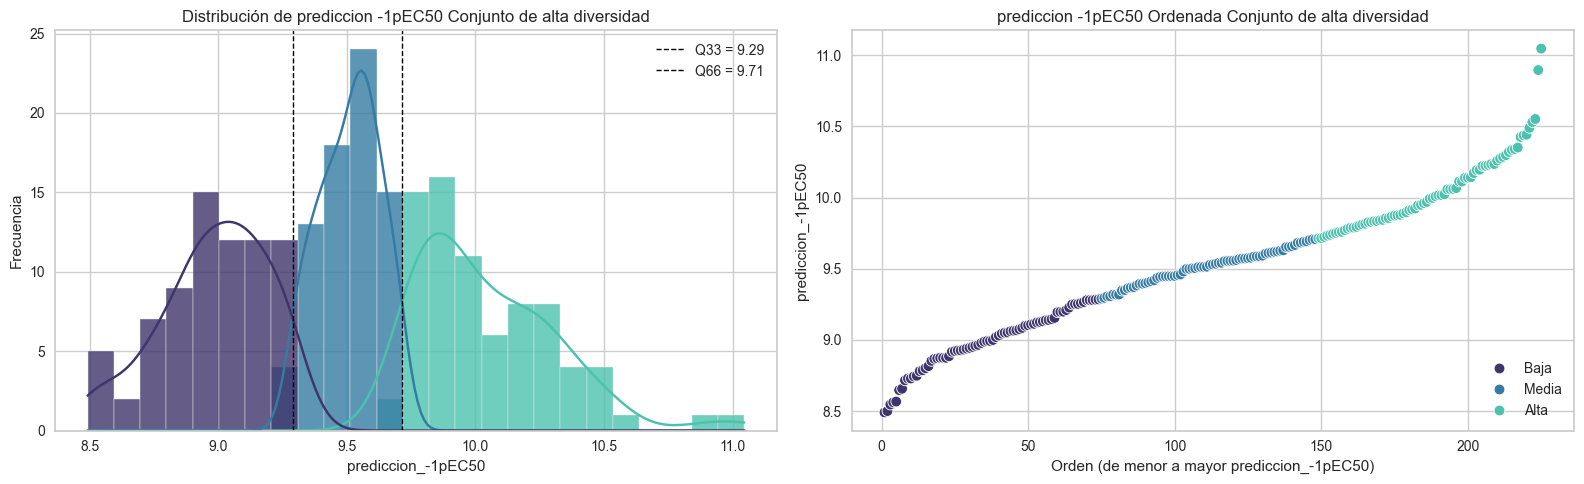


Resumen por categoría:
           n   promedio       min        max
Potencia                                    
Alta      77  10.045159  9.713811  11.045657
Baja      74   8.985231  8.491165   9.284582
Media     74   9.510922  9.290466   9.706269

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
121  AF-A0A672I3H1-F1           11.045657     Alta
83   AF-A0A437DK50-F1           10.895120     Alta
181      AF-L5LRQ3-F1           10.551372     Alta
132  AF-A0A6J2R6I7-F1           10.530062     Alta
40   AF-A0A3B3B937-F1           10.489078     Alta
172      AF-G1Q6H7-F1           10.441206     Alta
144  AF-A0A7J7WHB7-F1           10.436451     Alta
58   AF-A0A3P8V3F5-F1           10.425306     Alta
17   AF-A0A1L3MY50-F1           10.351054     Alta
34   AF-A0A2S0D696-F1           10.340347     Alta
131  AF-A0A6J2IF30-F1           10.334754     Alta
220    XP_027996892.1           10.319579     Alta
189      AF-P13189-F1           10.297869     Alta
129  AF-A0A6I9NZD6-F1           10.285366     Alta
190      AF-P20394-F1           10.273668     Alta

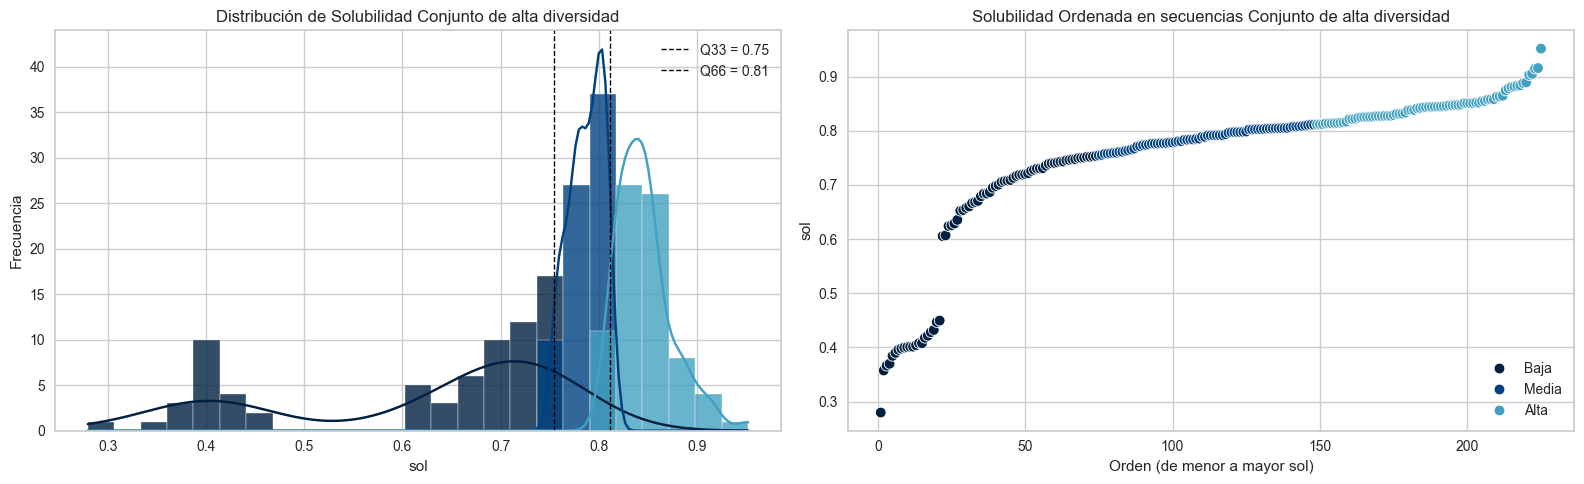


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      77  0.846210  0.811645  0.951705
Baja      74  0.618319  0.279729  0.753454
Media     74  0.787171  0.754591  0.811238

Top 15 registros de categoría "Alta":


ID       sol Potencia
143  AF-A0A7J5Z6B7-F1  0.951705     Alta
204      AF-Q7LZN2-F1  0.915737     Alta
167      AF-C0HJJ5-F1  0.914667     Alta
165      AF-C0HJJ3-F1  0.905193     Alta
206      AF-Q7LZN4-F1  0.902802     Alta
168      AF-C0HJJ6-F1  0.889321     Alta
76   AF-A0A3Q3FFF5-F1  0.887957     Alta
214       Dulaglutide  0.883833     Alta
222    XP_029460758.1  0.883336     Alta
217    NP_001079142.1  0.881748     Alta
177      AF-G3PL47-F1  0.881021     Alta
113  AF-A0A668UCV8-F1  0.878192     Alta
169      AF-C6EVG1-F1  0.874423     Alta
51   AF-A0A3B4GZV8-F1  0.864719     Alta
210      AF-Q9PUR0-F1  0.863256     Alta

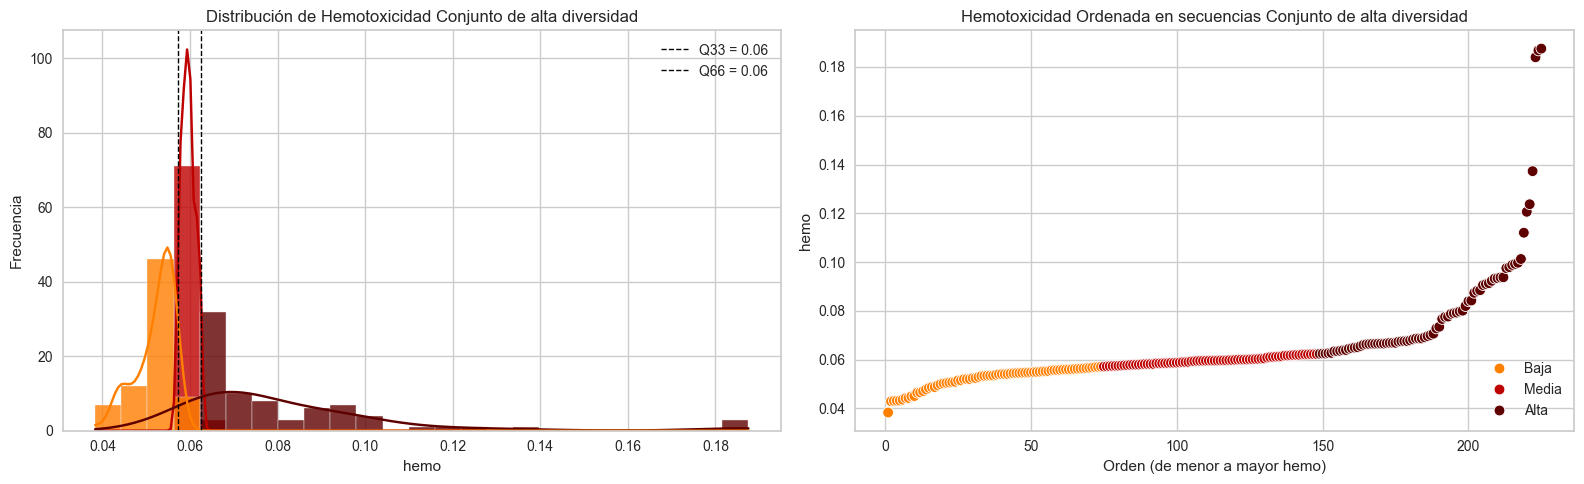


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      77  0.082112  0.062419  0.187523
Baja      74  0.052089  0.038335  0.057144
Media     74  0.059623  0.057190  0.062262

Top 15 registros de categoría "Alta":


ID      hemo Potencia
152  AF-A0A7L1V7B0-F1  0.187523     Alta
149  AF-A0A7K8VMT8-F1  0.186778     Alta
147  AF-A0A7K5DTR4-F1  0.183961     Alta
108  AF-A0A667XFV4-F1  0.137271     Alta
175      AF-G1QFC1-F1  0.123714     Alta
64   AF-A0A3Q0ST55-F1  0.120623     Alta
24   AF-A0A1S3NVN9-F1  0.112043     Alta
7    AF-A0A091P079-F1  0.101275     Alta
180      AF-H9GKR8-F1  0.099744     Alta
160  AF-A0A7L3GS93-F1  0.099264     Alta
159  AF-A0A7L3G0X3-F1  0.098834     Alta
154  AF-A0A7L2JAW6-F1  0.097947     Alta
156  AF-A0A7L2RU62-F1  0.097509     Alta
153  AF-A0A7L1V7E8-F1  0.093772     Alta
158  AF-A0A7L2YV14-F1  0.093714     Alta

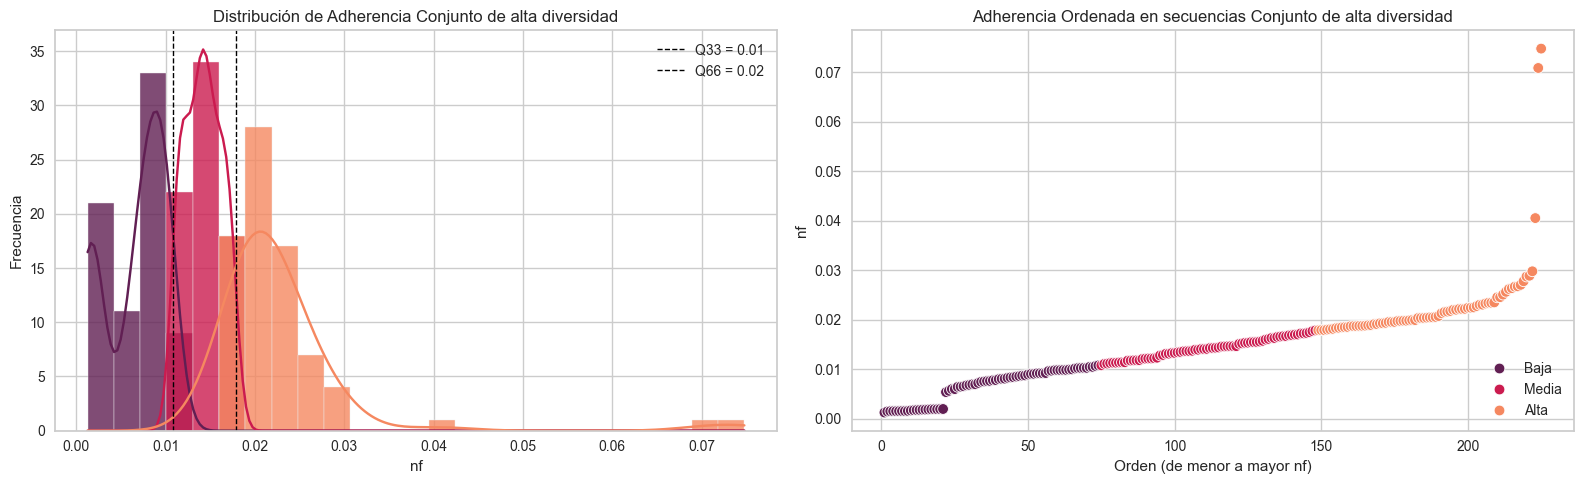


Resumen por categoría:
           n  promedio       min       max
Potencia                                  
Alta      77  0.022981  0.017887  0.074783
Baja      74  0.006612  0.001266  0.010794
Media     74  0.014216  0.010799  0.017850

Top 15 registros de categoría "Alta":


ID        nf Potencia
123  AF-A0A672NPW9-F1  0.074783     Alta
135  AF-A0A6P6M3Y7-F1  0.070871     Alta
188      AF-P0C235-F1  0.040546     Alta
124  AF-A0A672Q9F1-F1  0.029796     Alta
118  AF-A0A671T9R4-F1  0.028904     Alta
23   AF-A0A1S3MVQ3-F1  0.028741     Alta
207      AF-Q9DDE6-F1  0.027780     Alta
86   AF-A0A498N7U8-F1  0.027058     Alta
91   AF-A0A4W4FPL9-F1  0.026756     Alta
199      AF-Q6RYB3-F1  0.026699     Alta
194      AF-P68956-F1  0.026380     Alta
102  AF-A0A5C6PPH3-F1  0.026214     Alta
208      AF-Q9DG43-F1  0.025648     Alta
133  AF-A0A6J2V6I4-F1  0.025084     Alta
193      AF-P68274-F1  0.024579     Alta

In [16]:
%matplotlib inline 

clasificar_y_graficar_cuantiles(
    df_input=df_glp1,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de prediccion -1pEC50 Conjunto de alta diversidad',
    titulo_ordenado='prediccion -1pEC50 Ordenada Conjunto de alta diversidad')    
    
clasificar_y_graficar_cuantiles(
    df_input=df_glp1,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='ocean',
    titulo_distribucion='Distribución de Solubilidad Conjunto de alta diversidad',
    titulo_ordenado='Solubilidad Ordenada en secuencias Conjunto de alta diversidad'
)    

clasificar_y_graficar_cuantiles(
    df_input=df_glp1,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemotoxicidad Conjunto de alta diversidad',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias Conjunto de alta diversidad'
)

clasificar_y_graficar_cuantiles(
    df_input=df_glp1,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia Conjunto de alta diversidad',
    titulo_ordenado='Adherencia Ordenada en secuencias Conjunto de alta diversidad'
)


### Graficos de las Propiedades predichas en el conjunto de 

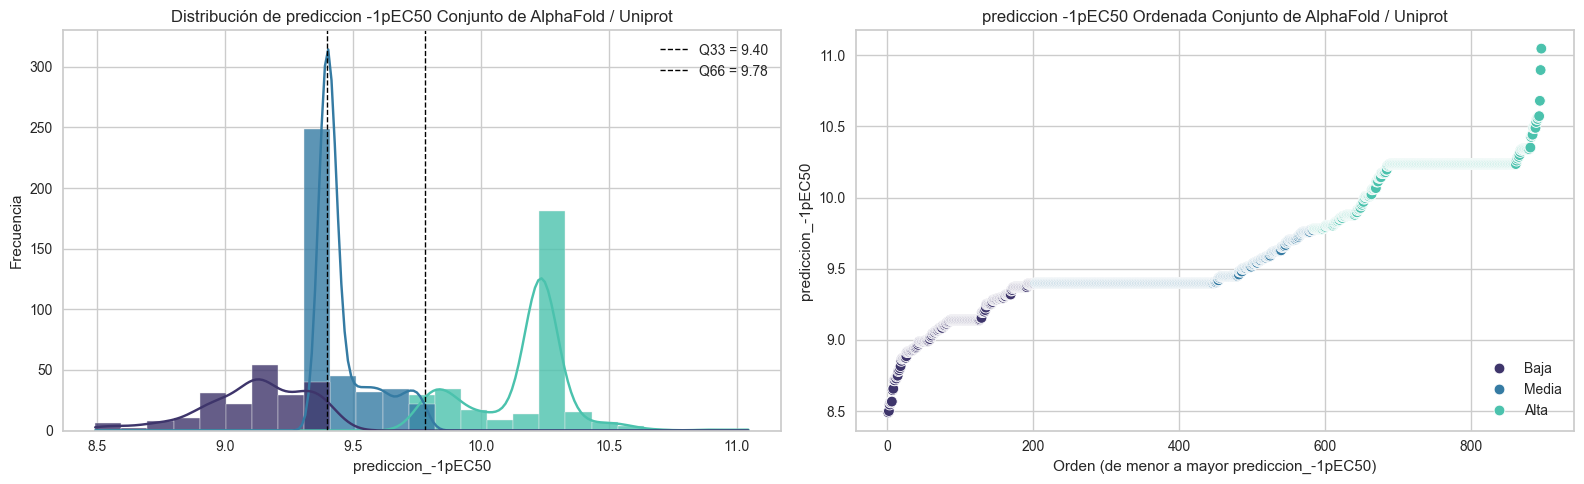


Resumen por categoría:
            n   promedio       min        max
Potencia                                     
Alta      313  10.155473  9.780633  11.045657
Baja      202   9.116771  8.491165   9.394925
Media     382   9.463666  9.398033   9.770343

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
301  AF-A0A672I3H1-F1           11.045657     Alta
232  AF-A0A437DK50-F1           10.895120     Alta
739      AF-U3KRF3-F1           10.679161     Alta
587  AF-A0A7S9CE09-F1           10.571419     Alta
312  AF-A0A673HLN7-F1           10.565879     Alta
671      AF-L5LRQ3-F1           10.551372     Alta
768    XP_006766620.1           10.551372     Alta
357  AF-A0A6J2R6I7-F1           10.530062     Alta
184  AF-A0A3P9LIZ7-F1           10.489078     Alta
129  AF-A0A3B3B937-F1           10.489078     Alta
182  AF-A0A3P9IFL7-F1           10.489078     Alta
657      AF-H2LC36-F1           10.489078     Alta
641      AF-G1Q6H7-F1           10.441206     Alta
398  AF-A0A7J7WHB7-F1           10.436451     Alta
174  AF-A0A3P8V3F5-F1           10.425306     Alta

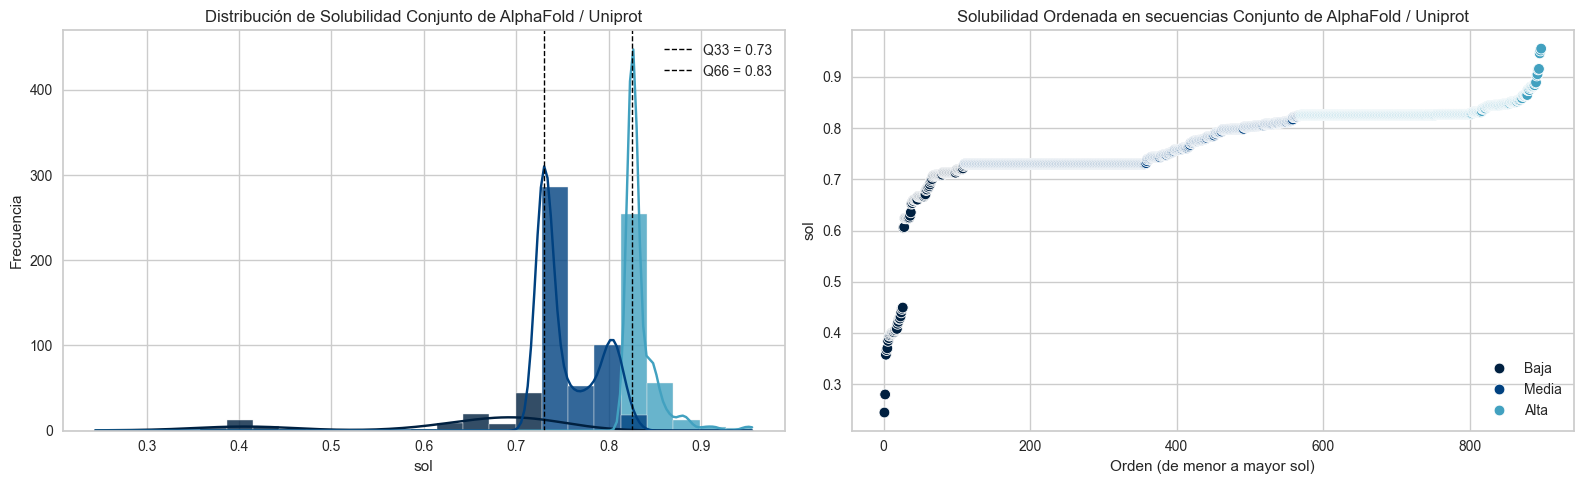


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      329  0.834488  0.825296  0.955395
Baja      110  0.617864  0.244463  0.728038
Media     458  0.755570  0.730178  0.824885

Top 15 registros de categoría "Alta":


ID       sol Potencia
704      AF-Q6IUP8-F1  0.955395     Alta
394  AF-A0A7J5Z6B7-F1  0.951705     Alta
312  AF-A0A673HLN7-F1  0.946053     Alta
720      AF-Q7LZN2-F1  0.915737     Alta
630      AF-C0HJJ5-F1  0.914667     Alta
628      AF-C0HJJ3-F1  0.905193     Alta
722      AF-Q7LZN4-F1  0.902802     Alta
631      AF-C0HJJ6-F1  0.889321     Alta
219  AF-A0A3Q3FFF5-F1  0.887957     Alta
745       Dulaglutide  0.883833     Alta
820    XP_029460758.1  0.883336     Alta
750    NP_001079142.1  0.881748     Alta
649      AF-G3PL53-F1  0.881021     Alta
648      AF-G3PL47-F1  0.881021     Alta
587  AF-A0A7S9CE09-F1  0.880162     Alta

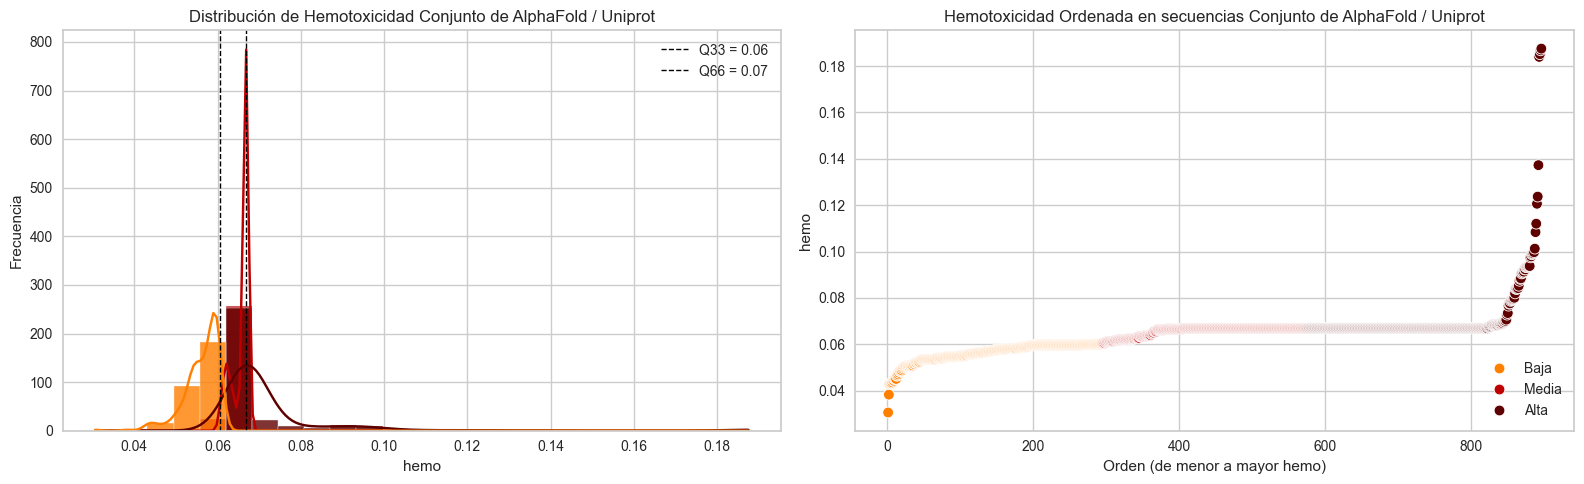


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      321  0.071912  0.066916  0.187523
Baja      295  0.056162  0.030618  0.060451
Media     281  0.065712  0.060497  0.066893

Top 15 registros de categoría "Alta":


ID      hemo Potencia
537  AF-A0A7L1V7B0-F1  0.187523     Alta
485  AF-A0A7K8VMT8-F1  0.186778     Alta
313  AF-A0A673HMH6-F1  0.185114     Alta
417  AF-A0A7K5DTR4-F1  0.183961     Alta
279  AF-A0A667XFV4-F1  0.137271     Alta
644      AF-G1QFC1-F1  0.123714     Alta
188  AF-A0A3Q0ST55-F1  0.120623     Alta
58   AF-A0A1S3NVN9-F1  0.112043     Alta
704      AF-Q6IUP8-F1  0.108387     Alta
13   AF-A0A091P079-F1  0.101275     Alta
663      AF-H9GKR8-F1  0.099744     Alta
564  AF-A0A7L3GS93-F1  0.099264     Alta
569  AF-A0A7L3M3E7-F1  0.099080     Alta
563  AF-A0A7L3G0X3-F1  0.098834     Alta
545  AF-A0A7L2JAW6-F1  0.097947     Alta

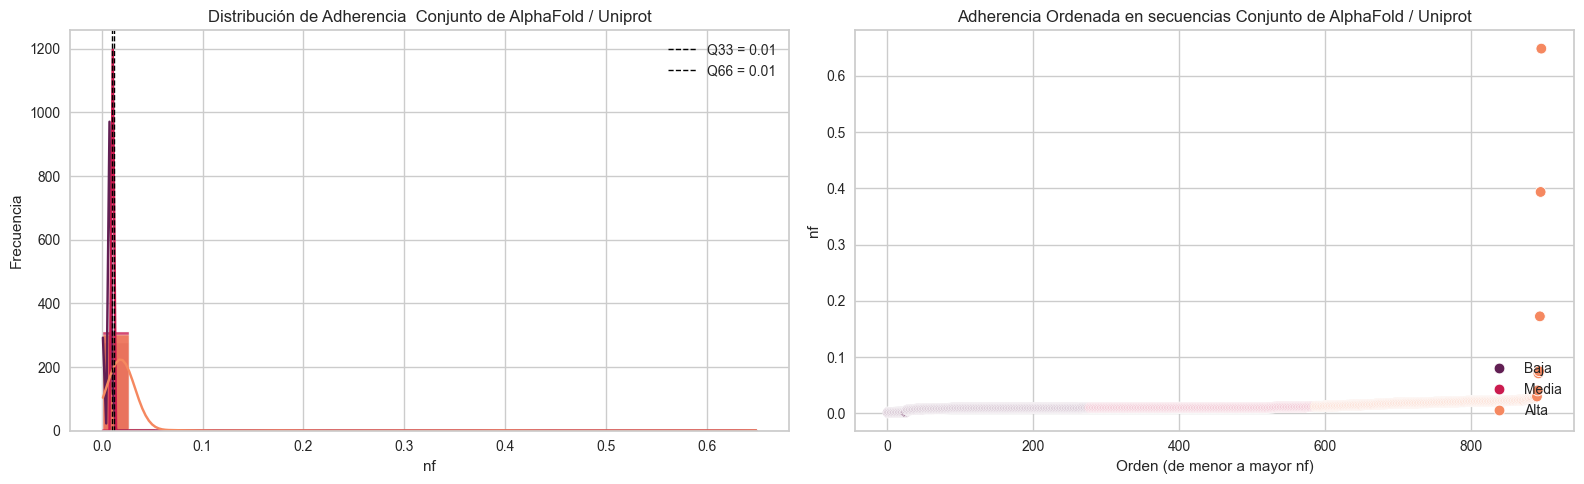


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      311  0.022861  0.012247  0.648717
Baja      277  0.008192  0.001266  0.009868
Media     309  0.010213  0.009954  0.012194

Top 15 registros de categoría "Alta":


ID        nf Potencia
312  AF-A0A673HLN7-F1  0.648717     Alta
587  AF-A0A7S9CE09-F1  0.393677     Alta
313  AF-A0A673HMH6-F1  0.172374     Alta
304  AF-A0A672NPW9-F1  0.074783     Alta
374  AF-A0A6P6M3Y7-F1  0.070871     Alta
684      AF-P0C235-F1  0.040546     Alta
306  AF-A0A672Q9F1-F1  0.029796     Alta
297  AF-A0A671T9R4-F1  0.028904     Alta
725      AF-Q91189-F1  0.028741     Alta
57   AF-A0A1S3MVQ3-F1  0.028741     Alta
727      AF-Q9DDE6-F1  0.027780     Alta
239  AF-A0A498N7U8-F1  0.027058     Alta
247  AF-A0A4W4FPL9-F1  0.026756     Alta
710      AF-Q6RYB3-F1  0.026699     Alta
694      AF-P68956-F1  0.026380     Alta

In [17]:
    
%matplotlib inline 

clasificar_y_graficar_cuantiles(
    df_input=df_glucagon_like_peptides,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de prediccion -1pEC50 Conjunto de AlphaFold / Uniprot',
    titulo_ordenado='prediccion -1pEC50 Ordenada Conjunto de AlphaFold / Uniprot')    
    
clasificar_y_graficar_cuantiles(
    df_input=df_glucagon_like_peptides,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='ocean',
    titulo_distribucion='Distribución de Solubilidad Conjunto de AlphaFold / Uniprot',
    titulo_ordenado='Solubilidad Ordenada en secuencias Conjunto de AlphaFold / Uniprot'
)    

clasificar_y_graficar_cuantiles(
    df_input=df_glucagon_like_peptides,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemotoxicidad Conjunto de AlphaFold / Uniprot',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias Conjunto de AlphaFold / Uniprot'
)

clasificar_y_graficar_cuantiles(
    df_input=df_glucagon_like_peptides,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia  Conjunto de AlphaFold / Uniprot',
    titulo_ordenado='Adherencia Ordenada en secuencias Conjunto de AlphaFold / Uniprot'
)

# Calculo de pEC50 sobre los datos de AlphaFold / Uniprot usados para entrenar los modelos generativos


### Como linea extra de investigación buscamos las especies de los péptidos con mayor actividad biológica a partir de los datos obtenidos de alpha fold

Destacan como resultados de interes las siguientes especies:

[Salarias fasciatus](https://es.wikipedia.org/wiki/Salarias_fasciatus)


[Oryzias javanicus](https://es.wikipedia.org/wiki/Oryzias_javanicus)


[Liraglutida, compuesto sintético](https://es.wikipedia.org/wiki/Liraglutida)


[Saccharomyces cerevisiae](https://es.wikipedia.org/wiki/Saccharomyces_cerevisiae)


[Emberiza bruniceps](https://es.wikipedia.org/wiki/Emberiza_bruniceps)


[Sinocyclocheilus rhinocerous](https://es.wikipedia.org/wiki/Sinocyclocheilus_rhinocerous)


[David's myotis](https://en.wikipedia.org/wiki/David%27s_myotis)


[Cottoperca gobio](https://en.wikipedia.org/wiki/Cottoperca_gobio)


[Oryzias latipes](https://es.wikipedia.org/wiki/Oryzias_latipes)


[Myotis lucifugus](https://es.wikipedia.org/wiki/Myotis_lucifugus)

Estas especies tiene un GLP-1 con mayor actividad biológica en comparación con el GLP-1 humano, de acuerdo con el modelo predictivo, lo cual es interesante para futuras investigaciones en el diseño de péptidos agonistas del receptor GLP-1.

In [18]:
# Union de los conjuntos de datos previo a la generación de nuevas secuencias

#unir todos los peptidos evaluados en un solo dataframe
df_todos_peptidos = pd.concat([df_pro_glucagon_humano, df_glucagon_like_peptides,df_125_conocidos, df_glp1, ], ignore_index=True)
# Eliminación de duplicados por secuencia
#df_todos_peptidos = df_todos_peptidos.drop_duplicates(subset=['sequence'])
df_todos_peptidos.shape

(1248, 1302)

In [19]:
# buscar los compuestos con mayor actividad de los que se conoce la especie

df_mejores_especies = df_todos_peptidos[df_todos_peptidos['Species'].notnull()].sort_values(by='prediccion_-1pEC50', ascending=False)
df_mejores_especies[['ID', 'Description', 'Species','organismCommonNames', 'prediccion_-1pEC50', 'sol', 'hemo', 'nf']].head(30)

ID                         Description  \
302  AF-A0A672I3H1-F1                          Glucagon a   
233  AF-A0A437DK50-F1             Uncharacterized protein   
740      AF-U3KRF3-F1                         Liraglutide   
588  AF-A0A7S9CE09-F1             Glucagon-like peptide 1   
313  AF-A0A673HLN7-F1  GLUCAGON domain-containing protein   
672      AF-L5LRQ3-F1                            Glucagon   
358  AF-A0A6J2R6I7-F1                     glucagon-1-like   
658      AF-H2LC36-F1             Uncharacterized protein   
183  AF-A0A3P9IFL7-F1                            Glucagon   
185  AF-A0A3P9LIZ7-F1                          Glucagon a   
130  AF-A0A3B3B937-F1                          Glucagon-1   
642      AF-G1Q6H7-F1                            Glucagon   
399  AF-A0A7J7WHB7-F1                            Glucagon   
175  AF-A0A3P8V3F5-F1                          Glucagon a   
47   AF-A0A1L3MY50-F1                            Glucagon   
95   AF-A0A2S0D696-F1                   Preproglucagon A2   
102  AF-A0A2S0D707-F1                   Preproglucagon B1   
290  AF-A0A670IXF6-F1             Uncharacterized protein   
291  AF-A0A670IXG1-F1  GLUCAGON domain-containing protein   
289  AF-A0A670IWE2-F1  GLUCAGON domain-containing protein   
97   AF-A0A2S0D698-F1                   Preproglucagon A1   
98   AF-A0A2S0D699-F1                  Preproglucagon B2s   
101  AF-A0A2S0D6T7-F1                  Preproglucagon A2s   
103  AF-A0A2S0D708-F1                   Preproglucagon B2   
587  AF-A0A7R5KHT1-F1        pro-glucagon-like isoform X1   
357  AF-A0A6J2IF30-F1           exendin-3-like isoform X2   
686      AF-P13189-F1                            Glucagon   
389  AF-A0A6P8U7R0-F1                     glucagon-1-like   
346  AF-A0A6I9NZD6-F1                     glucagon-1-like   
688      AF-P20394-F1                           Exendin-3   

                                     Species      organismCommonNames  \
302                       Salarias fasciatus          Jewelled blenny   
233                        Oryzias javanicus                      NaN   
740                 Saccharomyces cerevisiae                      NaN   
588  Emberiza bruniceps (red-headed bunting)                      NaN   
313             Sinocyclocheilus rhinocerous                      NaN   
672                           Myotis davidii           David's myotis   
358                         Cottoperca gobio                      NaN   
658                          Oryzias latipes                      NaN   
183                          Oryzias latipes       Japanese rice fish   
185                          Oryzias latipes       Japanese rice fish   
130                       Oryzias melastigma            Marine medaka   
642                         Myotis lucifugus         Little brown bat   
399                            Myotis myotis  Greater mouse-eared bat   
175                   Cynoglossus semilaevis              Tongue sole   
47                  Ornithorhynchus anatinus        Duckbill platypus   
95                 Takydromus tachydromoides                      NaN   
102                Takydromus tachydromoides                      NaN   
290                         Podarcis muralis                      NaN   
291                         Podarcis muralis              Wall lizard   
289                         Podarcis muralis              Wall lizard   
97                 Takydromus tachydromoides                      NaN   
98                 Takydromus tachydromoides                      NaN   
101                Takydromus tachydromoides                      NaN   
103                Takydromus tachydromoides                      NaN   
587    Pipra filicauda (Wire-tailed manakin)                      NaN   
357    Pipra filicauda (Wire-tailed manakin)                      NaN   
686                      Callorhinchus milii              Ghost shark   
389                     Gymnodraco acuticeps                      NaN   
346     No

In [20]:
## Resultados de la predicción de actividad biológica del pro-glucagon Humano como referencia
df_pro_glucagon_humano[['ID', 'Description', 'Species','organismCommonNames', 'prediccion_-1pEC50', 'sol', 'hemo', 'nf']]

ID Description          Species organismCommonNames  \
875  sp-P01275-GLUC_HUMAN    Glucagon  Pan troglodytes          Chimpanzee   

     prediccion_-1pEC50       sol      hemo        nf  
875           10.234846  0.825296  0.066893  0.009175

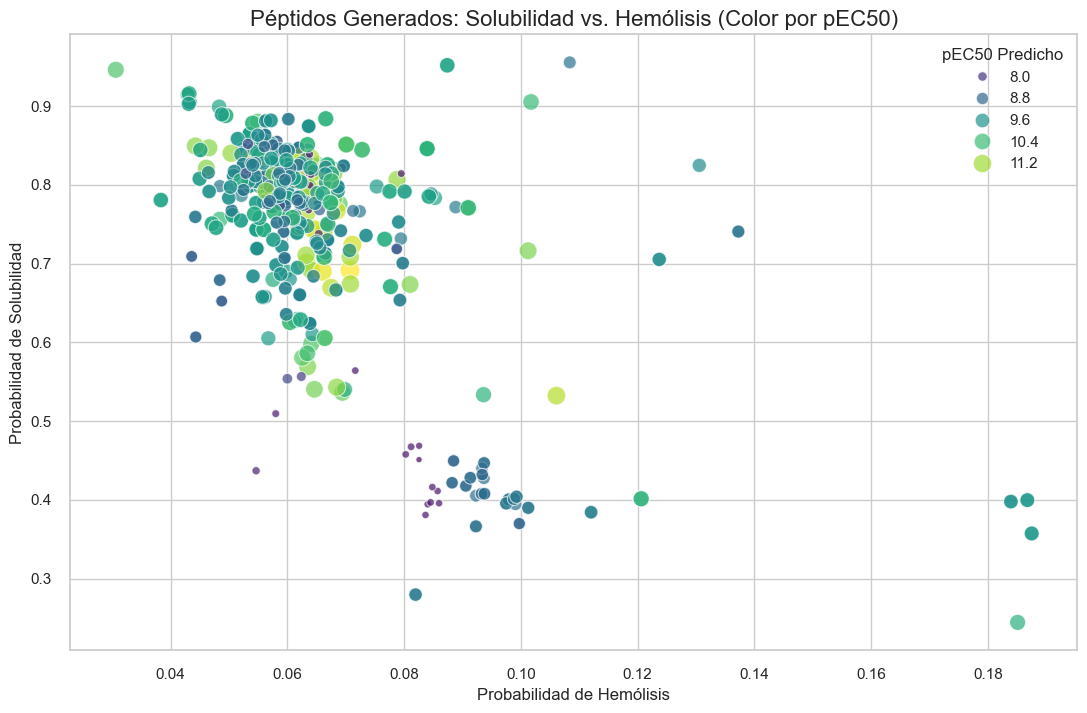

In [66]:
## Visualización de las propiedades predichas: Hemólisis vs Solubilidad coloreado por pEC50

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Crear el gráfico de dispersión
plt.figure(figsize=(13, 8))
scatter = sns.scatterplot(
    data=df_todos_peptidos, # Mostrar solo las 200 secuencias con mayor pEC50
    x='hemo',
    y='sol',
    hue='prediccion_-1pEC50',
    palette='viridis', # Usamos un mapa de color "viridis" donde los colores más claros indican valores más altos
    size='prediccion_-1pEC50', # El tamaño del punto también representará el pEC50
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='w'
)

# Añadir títulos y etiquetas
plt.title('Péptidos Generados: Solubilidad vs. Hemólisis (Color por pEC50)', fontsize=16)
plt.xlabel('Probabilidad de Hemólisis', fontsize=12)
plt.ylabel('Probabilidad de Solubilidad', fontsize=12)
plt.legend(title='pEC50 Predicho')
plt.grid(True)

# Mostrar el gráfico
plt.show()

-------

## Generación de nuevas secuencias usando modelos de lenguaje
Para la generación de nuevas secuencias peptídicas con potencial actividad agonista del receptor GLP-1, se emplean los modelos generativos de lenguaje ProxLNet y ProtGPT2. Estos modelos, basados en arquitecturas Transformer, han sido entrenados previamente con grandes conjuntos de datos de secuencias proteicas, lo que les permite capturar patrones complejos y generar nuevas secuencias coherentes y biológicamente plausibles.
Para esta atividad se entrenaron con el conjunto de datos de alta diversidad obtenidos de CD-Hit para facilitar la generación de secuencias con mayor similitud al GLP-1.

Como primer paso, se seleccionan las secuencias con mejores características de todo el conjunto para usarlas como prompt de inicio para la generación de nuevas secuencias.


In [21]:
# carga de Modelos de Machine Learning y Transformers
from sklearn.model_selection import train_test_split
from transformers import (
    XLNetLMHeadModel,
    XLNetTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import Dataset

from src.ProtXLNet_generator import generate_with_protxlnet_pipeline
from src.ProtGPT2_generator import generate_with_protgpt2_pipeline

import random
random.seed(132400)

In [22]:
# Selección de los mejores péptidos como prompts

df_seleccionadas = df_todos_peptidos.drop_duplicates('sequence').sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True])
# Filtrar predicciones con pEC50 > 10.6 y longitud <= 60
df_seleccionadas = df_seleccionadas[
    (df_seleccionadas['prediccion_-1pEC50'] > 10.6) & 
    (df_seleccionadas['sequence'].str.len() <= 60)]

df_seleccionadas.info()
display(df_seleccionadas[["ID","sequence","prediccion_-1pEC50","sol","hemo","nf","Species","organismCommonNames"]])

<class 'pandas.core.frame.DataFrame'>
Index: 54 entries, 923 to 932
Columns: 1302 entries, ID to -1pEC50
dtypes: category(3), float32(1293), float64(4), object(2)
memory usage: 311.8+ KB


ID                                   sequence  \
923          seq_pep26    YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSSGAPPPS   
990          seq_pep93              HSQGTFTSDYSKYLDSRAASEFVQWLISE   
924          seq_pep27    YSEGTFTSDYSKLLERQAIDEFVNWLLKGGPSSGAPPPS   
1012        seq_pep115              HAEGTFTSDVSSYLEGQAAKEFIAWLKGR   
982          seq_pep85             HSQGTFTSDYSKYLDSERARDFVAWLVAGG   
976          seq_pep79             HSIGTFTSDYSKYLDSERARDFVQWLVAGG   
961          seq_pep64             HSQGTFTSDYSKYLDSRSARDFVQWLVAGG   
1015        seq_pep118              HSQGTFTSDYSKYLEEEAVRLFICWLMNT   
981          seq_pep84             HSQGTFTSDYSKYLDSERARDFVEWLVAGG   
957          seq_pep60              HSQGTFTSDYSKYLDSRRASEFVQWLISG   
953          seq_pep56             HAEGTFTSDVSAYLEGQAAKEFIAWLVKGR   
979          seq_pep82             HSQGTFTSDYSKYLESERARDFVQWLVAGG   
963          seq_pep66             HSQGTFTSDYSKYLDEAAASDFVQWLVAGG   
980          seq_pep83             HSQGTFTSDYSKYLDSERAREFVQWLVAGG   
966          seq_pep69             HSQGTFTSDYSKYLDSERARDFVQWLVAGG   
985          seq_pep88             HSQGTFTSEYSKYLDSERARDFVQWLVAGG   
989          seq_pep92              HSQGTFTSDYSRYLDSRRASEFVQWLISE   
921          seq_pep24    YSEGTFTSDYSKLKEEEANRLFIEWLLAGGPSSGAPPPS   
904           seq_pep7              YSQGTFTSDYSKYLEEEAVRLFIEWLLAG   
964          seq_pep67             HSQGTFTSDYSKYLDSEAASDFVQWLVAGG   
960          seq_pep63             HSQGTFTSDYSKYLDRAAASDFVQWLVAGG   
978          seq_pep81             HSQGTFTSDYSEYLDSERARDFVQWLVAGG   
962          seq_pep65             HSQGTFTSDYSKYLDSRSASDFVQWLVAGG   
959          seq_pep62              HSQGTFTSDYSKYLDSRRASEFVQWLISE   
901           seq_pep4       HSQGTFTSDYSKYLDSRRAEDFVQWLVAGGSGSGSG   
987          seq_pep90              HSQGTFTSDYSKYLDSIRASEFVQWLISE   
907          seq_pep10   HSQGTFTSDYSKYLDSRAAACFVQWLLNGGPSSGAPPCGG   
965          seq_pep68             HSQGTFTSDYSKYLDSASASDFVQWLVAGG   
988          seq_pep91              HSQGTFTSDYSEYLDSRRASEFVQWLISE   
991          seq_pep94              HSIGTFTSDYSKYLDSRRASEFVQWLISE   
958          seq_pep61              HSQGTFTSDYSKYLDSRRASEFVQWLIAE   
922          seq_pep25    YSEGTFTSDLSILKEKEANREFVNWLLAGGPSSGAPPPS   
1011        seq_pep114              HAEGTFTSDVSSYLEGQAAKEFIAWVKGR   
909          seq_pep12  HSQGTFTSDYSKYLDSRCAAAFVQWLLNGGPSSGAPPPGCG   
1019        seq_pep122             HGEGTFTSDVSSYMESQLVDEFIAWLLKGR   
935          seq_pep38    YAEGTFTSDYSIYLDIKAAQEFVNWLLAGGPSSGAPPPS   
302   AF-A0A672I3H1-F1             HTDGTFTSDVSAYLNDRAVKEFVARLKSGQ   
986          seq_pep89              HSQGTFTSDYSKYLDSERASEFVQWLISE   
910          seq_pep13  HSQGTFTSDYSKYLDSRKAAAFVQWLLNGGPSSGAPPPGEG   
1018        seq_pep121             HGEGTFTSDVSSYMERQSVDEFIAWLLKGR   
908          seq_pep11   HSQGTFTSDYSKYLDSRAAAKFVQWLLNGGPSSGAPPEGG   
984          seq_pep87    HSQGTFTSDYSKYLDSERARDFVQWLISEGPSSGAPPPS   
939          seq_pep42    YAEGTFTSDYSIYLDKQAAEAFVNWLLAGGPSSGAPPPS   
1013        seq_pep116              HAEGTFTSDVSSYLEGQAAKEFIAWLVGR   
925          seq_pep28           LHAEGTFTSDVSSYLEGQAAKEFIAWLVKGRG   
906           seq_pep9             YSEGTFTSDYSKLLEEEAVRLFIEWLVKGP   
233   AF-A0A437DK50-F1             HADGTFTSDVSAYLKEQAIKDFVAKLKAGQ   
931          seq_pep34    YAEGTFTSDYSIYLDRQAAQEFVNWLLAGGPSSGAPPPS   
977          seq_pep80             HSMGTFTSDYSKYLDSERARDFVQWLVAGG   
933          seq_pep36    YAEGTFTSDYSIYLDEIAAQEFVNWLLAGGPSSGAPPPS   
983          seq_pep86              HSQGTFTSDYSKYLDSERARDFVQWLISE   
740       AF-U3KRF3-F1             HAEGTFTSDVSSYLEGQAAKEFIAWLVRGR   
940          seq_pep43    YAEGTFTSDYSIYLDKQAAYEFVNWLLAGGPSSGAPPPS   
932          seq_pep35    YAEGTFTSDYSIYLDEQAAQEFVNWLLAGGPSSGAPPPS   

      prediccion_-1pEC50       sol      hemo        nf  \
923            11.817376  0.691562  0.070741  0.011432   
990            11.658273  0.743250  0.064657  0.015408   
924            11.655141  0.690005  0.066039  0.01

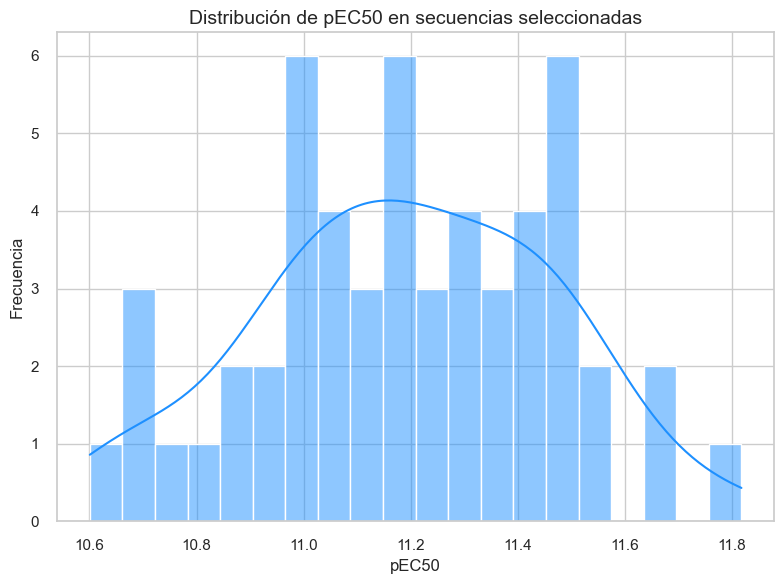

In [23]:
# Comparación de la distribución de pEC50 de las secuencias seleccionadas como semilla
import seaborn as sns
import matplotlib.pyplot as plt

# Configuración del estilo de la visualización
sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
sns.histplot(df_seleccionadas['prediccion_-1pEC50'], kde=True, bins=20, color='dodgerblue')
plt.title('Distribución de pEC50 en secuencias seleccionadas', fontsize=14)
plt.xlabel('pEC50', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.tight_layout()
plt.show()

In [24]:
# Preparación de los prompts para la generación de nuevas secuencias para los modelos
prompt_sequences= df_seleccionadas['sequence'].tolist()
longitud_maxima = df_seleccionadas['sequence'].str.len().max()
longitud_minima = df_seleccionadas['sequence'].str.len().min()
sequences_base = df_seleccionadas['sequence'].tolist()
print(f"Longitud máxima de secuencia: {longitud_maxima}")
print(f"Longitud mínima de secuencia: {longitud_minima}")

Longitud máxima de secuencia: 41
Longitud mínima de secuencia: 29


### Generación de secuencias usando ProtGPT2

#### ProtGPT2

ProtGPT2 es un modelo de lenguaje especializado en el espacio proteico, diseñado para la generación de novo de secuencias peptídicas y proteínas. Las secuencias que produce conservan propiedades esenciales de las proteínas naturales, como propensión de aminoácidos, estructura secundaria y globularidad, mientras exploran regiones inéditas del espacio de diseño.

Basado en la arquitectura Transformer tipo GPT-2, ProtGPT2 cuenta con 36 capas, una dimensionalidad de 1280 y aproximadamente 738 millones de parámetros. Fue preentrenado en modo decodificador sobre la base UniRef50 (versión 2021_04), utilizando secuencias sin anotaciones bajo un enfoque auto-supervisado mediante un objetivo causal de predicción del siguiente token. Esto le permite aprender representaciones internas del “lenguaje” de las proteínas y generar secuencias coherentes y biológicamente plausibles.

En esta actividad se entreno el modelo usando el conjuntos de datos de alta diversidad de 225 Peptidos usando el script de entrenamiento proporcionado por los desarrolladores de ProtGPT2, ajustando hiperparámetros como la tasa de aprendizaje, el tamaño del lote y el número de épocas para optimizar la generación de secuencias con características deseables.

In [25]:
# Generar un timestamp para nombrar archivos a final de evitar sobreescrituras de resultados
from datetime import datetime
# Generar timestamp en formato AñoMesDía_HoraMinutoSegundo
File_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [26]:
# Generación de nuevas secuencias usando ProtGPT2
variants = generate_with_protgpt2_pipeline(
    prompt_sequences=prompt_sequences,
    num_variants_per_seq=20,
    num_return_sequences=5,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)
df_secuencias_protGPT2 = pd.DataFrame(variants, columns=["sequence"])
df_secuencias_protGPT2['ID'] = [f"secuencia_{idx}" for idx in range(1, len(df_secuencias_protGPT2) + 1)]
df_secuencias_protGPT2 = df_secuencias_protGPT2[['ID', 'sequence']]
df_secuencias_protGPT2.head(10)

Usando dispositivo: cuda
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/54 [00:00<?, ?it/s]

Generando 1071 variantes (el pipeline manejará los lotes)...
Procesando salidas...


Procesando:   0%|          | 0/1071 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 5109 variantes únicas.


ID                                   sequence
0   secuencia_1  HYEGTFTSDVSSYLEGQAAKEFIAWLKGRFQGEVIPVAGST
1   secuencia_2  YAEGTFTSDYSIYLDRQAAQYFVNWLLALGDSYYDEYPTYI
2   secuencia_3  LHAEGTFTGDVSSYLEGQAAKEFIAWLVKGRGVDGPARSAL
3   secuencia_4  HSQGTFTSDYSRQLDSRRASEFVQWLISEKGCTEGDIAFLT
4   secuencia_5  HSQVTFTSDYSKYLDSERAREFVQWLVAGGVSVDLDDGRVF
5   secuencia_6  HSMGTFTSFYSKYLDSERARDFVQWLVAGGARCSTDRNFYN
6   secuencia_7  HSQGTFTSDYSKYLDSERARDFVAWLVATGAKPEEIVVSSF
7   secuencia_8  HSQGTFTSDYSEYLDSERARDFVQWSVAGGARVFLFDTWWF
8   secuencia_9  HSQGTFTSYYSKYLDSRAAACFVQWLLNGGPSSGAPPCGGP
9  secuencia_10  HSQGTFTSDYSRYLDSRRGSEFVQTTVWSSFLLLLVFLCGC

#### Cálculo de las características necesarias para la predicción de la actividad biológica

In [27]:
# Cálculo de descriptores y actividad biológica predicha para las nuevas secuencias generadas con ProtGPT2

df_secuencias_protGPT2 = calcular_descriptores_ifeature(
        directorio_temporal=directorio_temporal,
        dataframe=df_secuencias_protGPT2,
        sequence_col='sequence',
        id_col='ID',
        descriptores=descriptores,
        ifeatures_settings_json=ifeatures_settings_json
    )
    
# Calculo de pEC50 sobre los datos de alpha fold y uniprot
df_secuencias_protGPT2 = predict_model(modelo_pycaret, data=df_secuencias_protGPT2)
df_secuencias_protGPT2.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_secuencias_protGPT2 = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_secuencias_protGPT2, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)
 

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_223750.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_223750.fasta...
  - OK! File is structurally valid. Found 5109 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_223750.fasta' es válido. Se encontraron 5109 registros.
Iniciando cálculo de 14 descriptores...


calculando descriptores:   0%|          | 0/14 [00:00<?, ?it/s]

File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
Cálculo de descriptores finalizado.
Descriptores unidos al DataFrame. Forma final: (5109, 1292)
Archivo temporal 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_223750.fasta' eliminado.
Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/5109 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/5109 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/5109 [00:00<?, ?it/s]

In [28]:
# guardar en un archivo CSV las nuevas secuencias generadas
nombre_archivo = f"secuencias_nuevas_prot_gpt2_{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"
nombre_archivo


'secuencias_nuevas_prot_gpt2_20251026_223719'

In [29]:
# Guardar el DataFrame en CSV
ruta_salida_secuencias_nuevas = Path(directorio_nuevas_secuencias /nombre_archivo_csv)

df_secuencias_protGPT2.to_csv(ruta_salida_secuencias_nuevas, index=False)
print(f"Archivo guardado: {ruta_salida_secuencias_nuevas}")

Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_prot_gpt2_20251026_223719.csv


### Resultados de la generación de nuevas secuencias con ProtGPT2

Las secuencias de ProtGPT2 tienen diversidad de aminoacidos y propiedades fisicoquímicas adecuadas para su evaluación como posibles agonistas del receptor GLP-1.

In [31]:
#Top  de secuencias generadas por propiedades deseadas 
df_secuencias_protGPT2.sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True], inplace=True)
df_secuencias_protGPT2[["ID","sequence","sol","hemo", "nf","prediccion_-1pEC50"]].head()


ID                                   sequence       sol  \
5004  secuencia_5005  YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSSVAPPPSAP  0.651837   
1691  secuencia_1692  YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSWGAPPPSAS  0.653030   
517    secuencia_518  YSEGTFVSDYSKLLEEEAVRDFIEWLLAGGPSSGAPPPSAG  0.688878   
3974  secuencia_3975  LSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPSSGAPPPSAA  0.654717   
276    secuencia_277  YSEGTFTSDYSKLLERQAIDEFVFWLLKGGPSSGAPPPSAG  0.668168   

          hemo        nf  prediccion_-1pEC50  
5004  0.068348  0.008918           11.840127  
1691  0.071229  0.007569           11.774935  
517   0.070832  0.008930           11.749581  
3974  0.069787  0.006893           11.745624  
276   0.068964  0.009033           11.737937

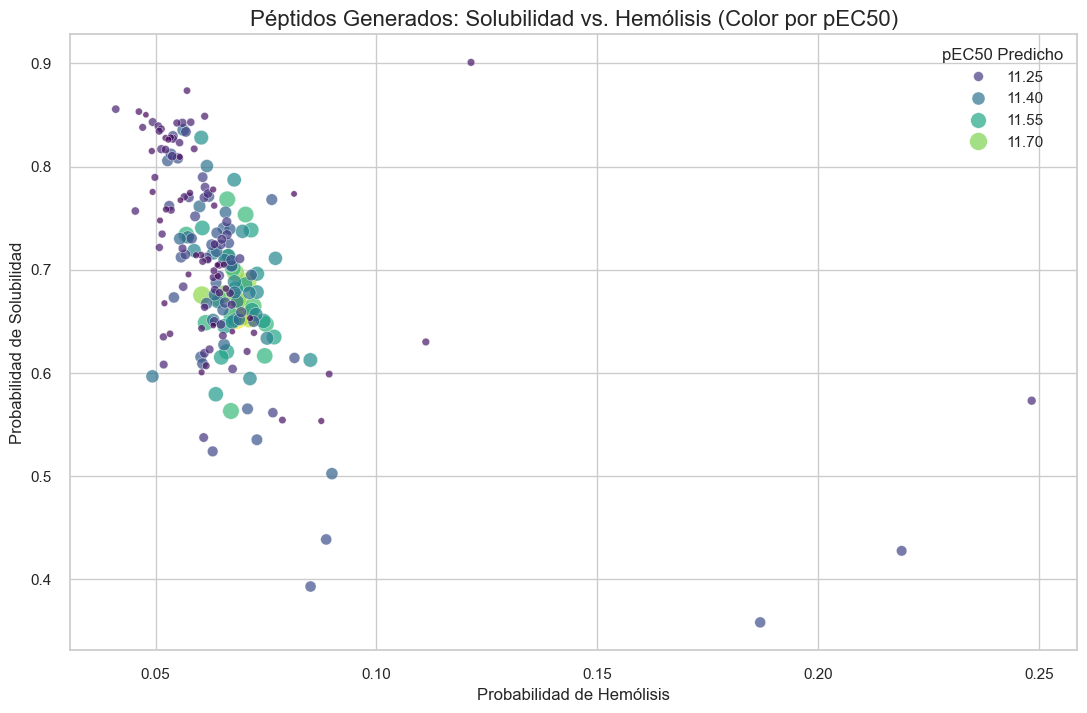

In [63]:
## Visualización de las propiedades predichas: Hemólisis vs Solubilidad coloreado por pEC50

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Crear el gráfico de dispersión
plt.figure(figsize=(13, 8))
scatter = sns.scatterplot(
    data=df_secuencias_protGPT2.head(200), # Mostrar solo las 200 secuencias con mayor pEC50
    x='hemo',
    y='sol',
    hue='prediccion_-1pEC50',
    palette='viridis', # Usamos un mapa de color "viridis" donde los colores más claros indican valores más altos
    size='prediccion_-1pEC50', # El tamaño del punto también representará el pEC50
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='w'
)

# Añadir títulos y etiquetas
plt.title('Péptidos Generados: Solubilidad vs. Hemólisis (Color por pEC50)', fontsize=16)
plt.xlabel('Probabilidad de Hemólisis', fontsize=12)
plt.ylabel('Probabilidad de Solubilidad', fontsize=12)
plt.legend(title='pEC50 Predicho')
plt.grid(True)

# Mostrar el gráfico
plt.show()

#### Gráficos de las propiedades obtenias con ProtGPT2


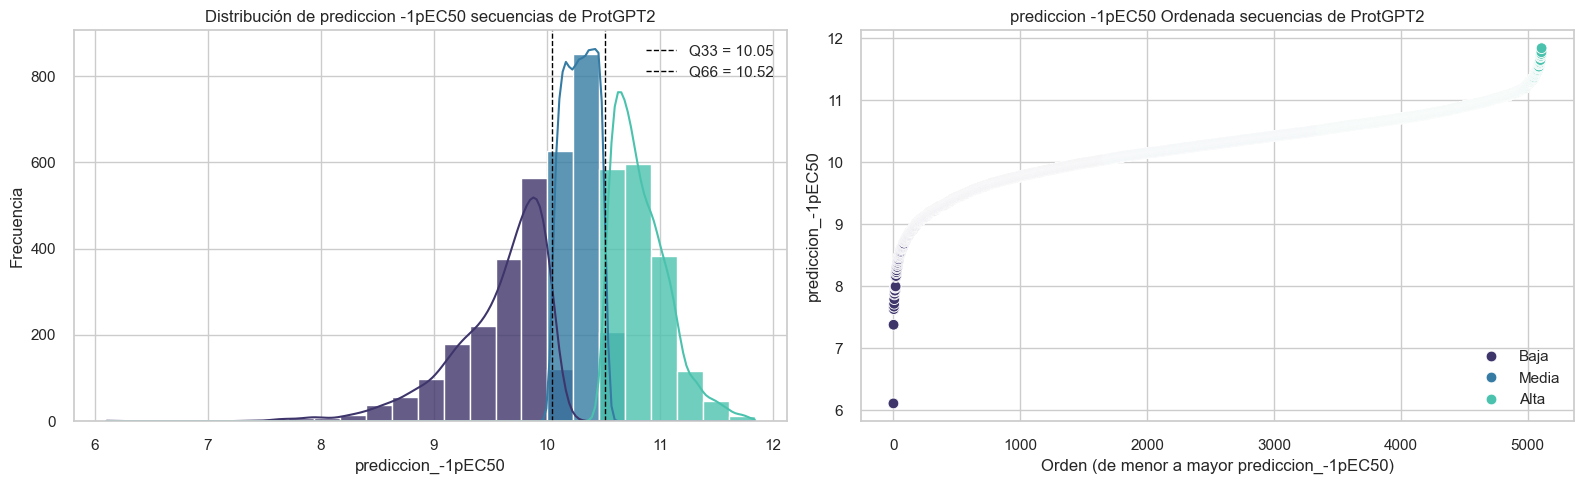


Resumen por categoría:
             n   promedio        min        max
Potencia                                       
Alta      1737  10.838746  10.518702  11.840127
Baja      1686   9.563515   6.107145  10.045160
Media     1686  10.291403  10.045923  10.518688

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
5004  secuencia_5005           11.840127     Alta
1691  secuencia_1692           11.774935     Alta
517    secuencia_518           11.749581     Alta
3974  secuencia_3975           11.745624     Alta
276    secuencia_277           11.737937     Alta
3279  secuencia_3280           11.716975     Alta
930    secuencia_931           11.711308     Alta
2396  secuencia_2397           11.707943     Alta
1577  secuencia_1578           11.696462     Alta
2704  secuencia_2705           11.649246     Alta
295    secuencia_296           11.640024     Alta
4359  secuencia_4360           11.629760     Alta
3528  secuencia_3529           11.610798     Alta
1702  secuencia_1703           11.610385     Alta
2467  secuencia_2468           11.604612     Alta

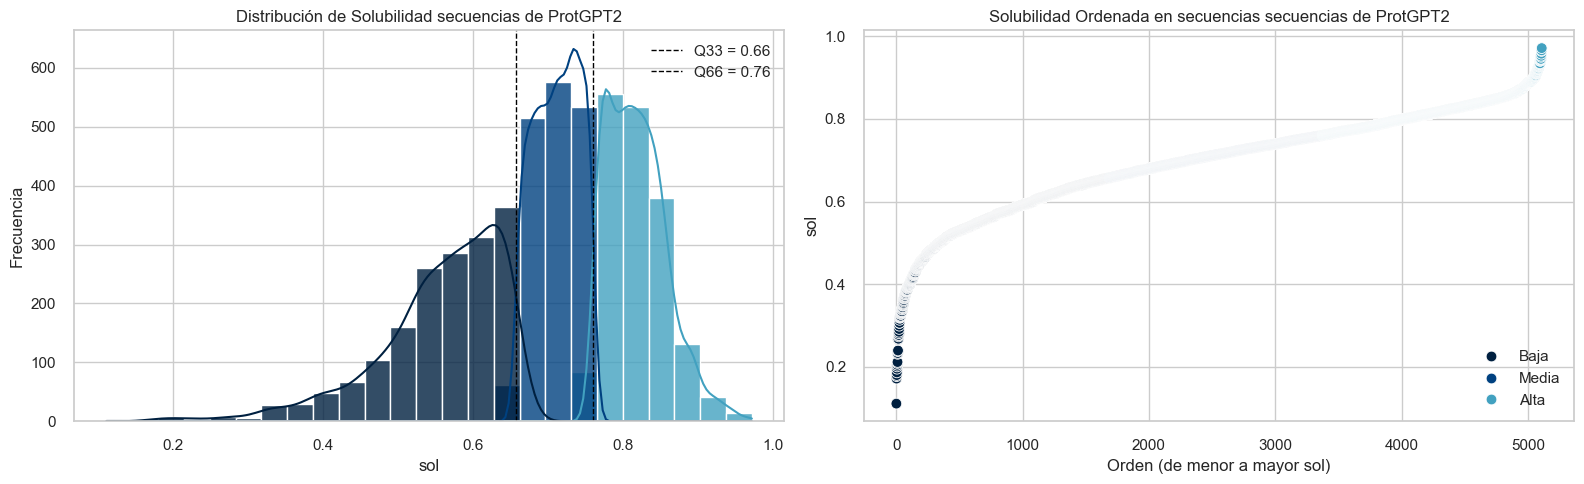


Resumen por categoría:
             n  promedio       min       max
Potencia                                    
Alta      1737  0.818263  0.760205  0.971498
Baja      1686  0.555786  0.111292  0.657721
Media     1686  0.711525  0.657734  0.760174

Top 15 registros de categoría "Alta":


ID       sol Potencia
1368  secuencia_1369  0.971498     Alta
3369  secuencia_3370  0.966132     Alta
3750  secuencia_3751  0.964624     Alta
4616  secuencia_4617  0.958024     Alta
273    secuencia_274  0.952998     Alta
1269  secuencia_1270  0.950395     Alta
2998  secuencia_2999  0.945435     Alta
3822  secuencia_3823  0.945000     Alta
1247  secuencia_1248  0.944949     Alta
2586  secuencia_2587  0.944186     Alta
2872  secuencia_2873  0.943860     Alta
4319  secuencia_4320  0.941781     Alta
2730  secuencia_2731  0.941347     Alta
3504  secuencia_3505  0.940653     Alta
648    secuencia_649  0.934736     Alta

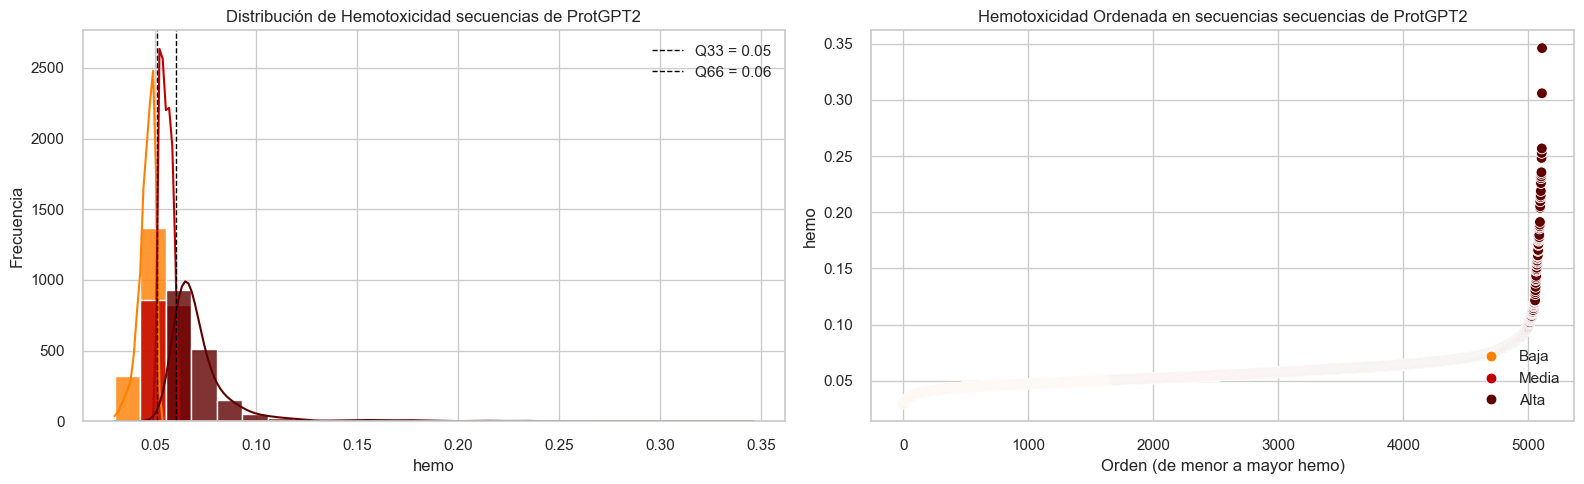


Resumen por categoría:
             n  promedio       min       max
Potencia                                    
Alta      1737  0.073922  0.060092  0.346090
Baja      1686  0.045609  0.029779  0.050807
Media     1686  0.055147  0.050809  0.060071

Top 15 registros de categoría "Alta":


ID      hemo Potencia
90      secuencia_91  0.346090     Alta
266    secuencia_267  0.305892     Alta
1776  secuencia_1777  0.256828     Alta
4327  secuencia_4328  0.252801     Alta
4655  secuencia_4656  0.248372     Alta
2107  secuencia_2108  0.235623     Alta
1422  secuencia_1423  0.234131     Alta
4577  secuencia_4578  0.232006     Alta
2318  secuencia_2319  0.230307     Alta
332    secuencia_333  0.226011     Alta
3923  secuencia_3924  0.218925     Alta
2226  secuencia_2227  0.214922     Alta
4119  secuencia_4120  0.213485     Alta
4113  secuencia_4114  0.213357     Alta
3649  secuencia_3650  0.209795     Alta

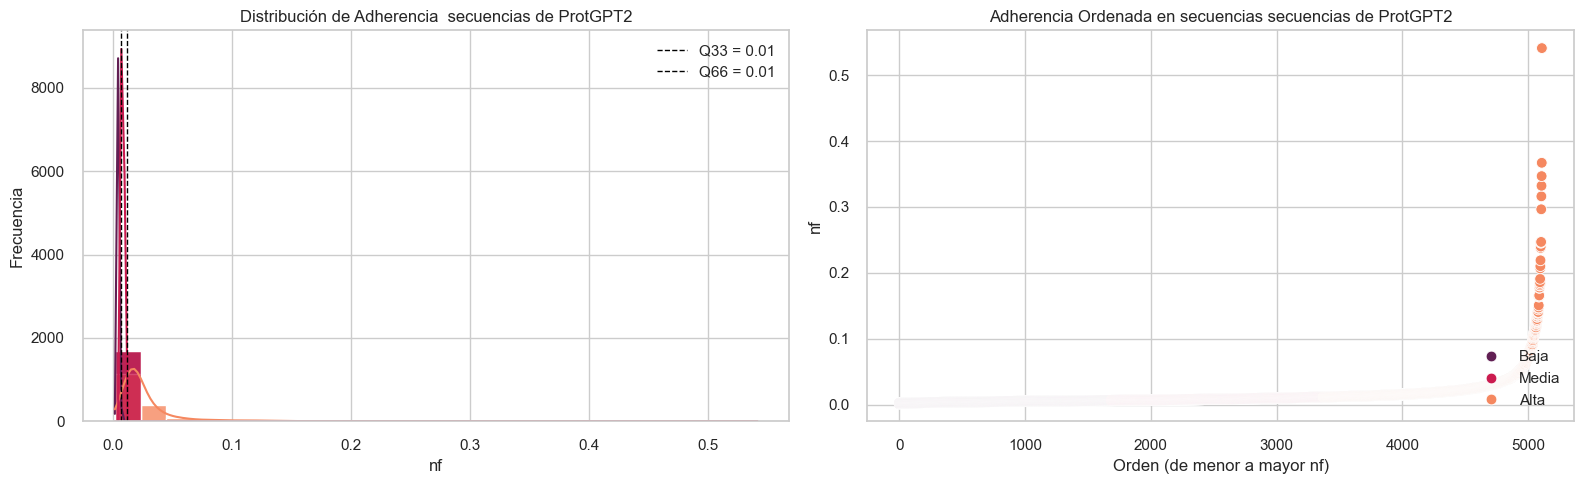


Resumen por categoría:
             n  promedio       min       max
Potencia                                    
Alta      1737  0.029004  0.011531  0.541063
Baja      1686  0.004582  0.001458  0.006391
Media     1686  0.008598  0.006392  0.011530

Top 15 registros de categoría "Alta":


ID        nf Potencia
993    secuencia_994  0.541063     Alta
2207  secuencia_2208  0.366977     Alta
800    secuencia_801  0.346758     Alta
2872  secuencia_2873  0.332110     Alta
1968  secuencia_1969  0.316084     Alta
2267  secuencia_2268  0.296419     Alta
3750  secuencia_3751  0.246887     Alta
3645  secuencia_3646  0.246288     Alta
2870  secuencia_2871  0.245598     Alta
2432  secuencia_2433  0.239841     Alta
3185  secuencia_3186  0.237730     Alta
3401  secuencia_3402  0.218951     Alta
1694  secuencia_1695  0.210089     Alta
456    secuencia_457  0.206736     Alta
2400  secuencia_2401  0.190773     Alta

In [32]:
# Generación de gráficos de las nuevas secuencias generadas con ProtGPT2
%matplotlib inline 

clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protGPT2,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de prediccion -1pEC50 secuencias de ProtGPT2',
    titulo_ordenado='prediccion -1pEC50 Ordenada secuencias de ProtGPT2')    
    
clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protGPT2,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='ocean',
    titulo_distribucion='Distribución de Solubilidad secuencias de ProtGPT2',
    titulo_ordenado='Solubilidad Ordenada en secuencias secuencias de ProtGPT2'
)    

clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protGPT2,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemotoxicidad secuencias de ProtGPT2',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias secuencias de ProtGPT2'
)

clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protGPT2,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia  secuencias de ProtGPT2',
    titulo_ordenado='Adherencia Ordenada en secuencias secuencias de ProtGPT2'
)

## Generación de nuevas secuencias peptídicas agonistas de GLP-1 utilizando ProXLNET

### Modelo ProXLNet entrenado descongelando 10 capas de 30

In [ ]:
# Genera time stamp

from datetime import datetime
# Generar timestamp en formato AñoMesDía_HoraMinutoSegundo
File_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

In [ ]:
# Generación de nuevas secuencias usando ProtXLNet
variants = generate_with_protxlnet_pipeline(
    ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet_finetuned",
    prompt_sequences=prompt_sequences,
    num_variants_per_seq=30,
    num_return_sequences=5,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)
df_secuencias_protxlnet = pd.DataFrame(variants, columns=["sequence"])


Usando dispositivo: cuda
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/54 [00:00<?, ?it/s]

Generando 1589 variantes (el pipeline manejará los lotes)...
Procesando salidas...


Procesando:   0%|          | 0/1589 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 1589 variantes únicas.


In [ ]:
# Ajuste de las secuencias y filtrado
allowed_chars = "ACDEFGHIKLMNPQRSTVWY"
pattern_to_remove = f"[^{allowed_chars}]"

df_secuencias_protxlnet['sequence'] = df_secuencias_protxlnet['sequence'].str.replace(pattern_to_remove, '', regex=True)
                        
df_secuencias_protxlnet['ID'] = [f"secuencia_{idx}" for idx in range(1, len(df_secuencias_protxlnet) + 1)]
df_secuencias_protxlnet = df_secuencias_protxlnet[['ID', 'sequence']]
df_secuencias_protxlnet.head(10)

ID                                 sequence
0   secuencia_1                HSQGTFPSDYSKYLDSRRASEFVQW
1   secuencia_2           HSQGTFCSDYSKYLESERARDDGGGGGGGG
2   secuencia_3  YAEGTFTSDYSIYLDKQALEAFVNWLLAGGPSSGAPPPS
3   secuencia_4  YAEGTFTSDYAIYLDKQAAEAFVNWLLAGGPSSGAPPPS
4   secuencia_5           HSQGTFTSDYSKYRDEAAASDFVQWLVAGG
5   secuencia_6           HTDGTFTSDVSAYLNDRAVKEFVARLKSAQ
6   secuencia_7               HSQGTFTSDYSKYSDSRDDDDDDDDD
7   secuencia_8  YAEGTFTSDYSIYLDEQAAQEFVNWLLAGGPSSGAPWPS
8   secuencia_9           HSQHTFTSDYSKYLDSERARDFVQWLVAGG
9  secuencia_10                                   HSQGHF

#### Cálculo de las características necesarias para la predicción de la actividad biológica

In [42]:
# Cálculo de descriptores y actividad biológica predicha para las nuevas secuencias generadas con ProtXLNET

df_secuencias_protxlnet = calcular_descriptores_ifeature(
        directorio_temporal=directorio_temporal,
        dataframe=df_secuencias_protxlnet,
        sequence_col='sequence',
        id_col='ID',
        descriptores=descriptores,
        ifeatures_settings_json=ifeatures_settings_json
    )
    
# Calculo de pEC50 sobre los datos de alpha fold y uniprot
df_secuencias_protxlnet = predict_model(modelo_pycaret, data=df_secuencias_protxlnet)
df_secuencias_protxlnet.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_secuencias_protxlnet = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_secuencias_protxlnet, 
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_230717.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_230717.fasta...
  - OK! File is structurally valid. Found 1589 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_230717.fasta' es válido. Se encontraron 1589 registros.
Iniciando cálculo de 14 descriptores...


calculando descriptores:   0%|          | 0/14 [00:00<?, ?it/s]

File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
Cálculo de descriptores finalizado.
Descriptores unidos al DataFrame. Forma final: (1589, 1292)
Archivo temporal 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_230717.fasta' eliminado.
Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/1589 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/1589 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/1589 [00:00<?, ?it/s]

In [43]:
# guardar en un archivo CSV las nuevas secuencias generadas

# Guardar df_secuencias_nuevas en CSV con timestamp

nombre_archivo = f"secuencias_nuevas_protxlnet_{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"

In [44]:
# Guardar el DataFrame en CSV
ruta_salida_secuencias_nuevas = Path(directorio_nuevas_secuencias /nombre_archivo_csv)

df_secuencias_protxlnet.to_csv(ruta_salida_secuencias_nuevas, index=False)
print(f"Archivo guardado: {ruta_salida_secuencias_nuevas}")

Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_protxlnet_20251026_224516.csv


### Resultados de la generación de nuevas secuencias con ProXLNET 

In [46]:
#Top  de secuencias generadas por propiedades deseadas 
df_secuencias_protxlnet.sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True], inplace=True)
df_secuencias_protxlnet[["ID","sequence","sol","hemo", "nf","prediccion_-1pEC50"]].head()

ID                                 sequence       sol  \
1195  secuencia_1196                                    HSDGT  0.901513   
1331  secuencia_1332                                    HSEGT  0.930686   
344    secuencia_345                                    HSIGV  0.707493   
1405  secuencia_1406  YSEGTFTSDYSKLLEEEAVRDFIEWYLAGGPSSGAPPPS  0.705491   
20      secuencia_21  YSEGTFTSDYSKLLEEEAVRDFIEWLLAGGPPSGAPPPS  0.708519   

          hemo        nf  prediccion_-1pEC50  
1195  0.054647  0.592403           12.031101  
1331  0.053785  0.583084           12.013793  
344   0.099761  0.266168           11.951956  
1405  0.063853  0.013329           11.949434  
20    0.067945  0.012646           11.861790

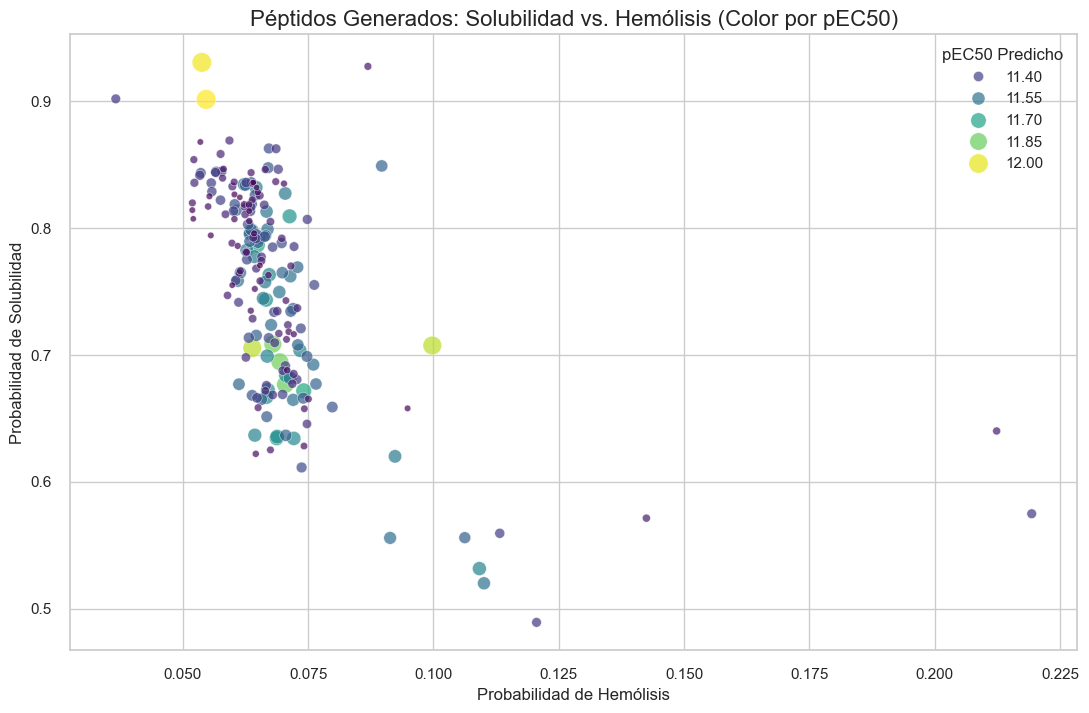

In [62]:
## Visualización de las propiedades predichas: Hemólisis vs Solubilidad coloreado por pEC50

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Crear el gráfico de dispersión
plt.figure(figsize=(13, 8))
scatter = sns.scatterplot(
    data=df_secuencias_protxlnet.head(200), # Mostrar solo las 200 secuencias con mayor pEC50
    x='hemo',
    y='sol',
    hue='prediccion_-1pEC50',
    palette='viridis', # Usamos un mapa de color "viridis" donde los colores más claros indican valores más altos
    size='prediccion_-1pEC50', # El tamaño del punto también representará el pEC50
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='w'
)

# Añadir títulos y etiquetas
plt.title('Péptidos Generados: Solubilidad vs. Hemólisis (Color por pEC50)', fontsize=16)
plt.xlabel('Probabilidad de Hemólisis', fontsize=12)
plt.ylabel('Probabilidad de Solubilidad', fontsize=12)
plt.legend(title='pEC50 Predicho')
plt.grid(True)

# Mostrar el gráfico
plt.show()

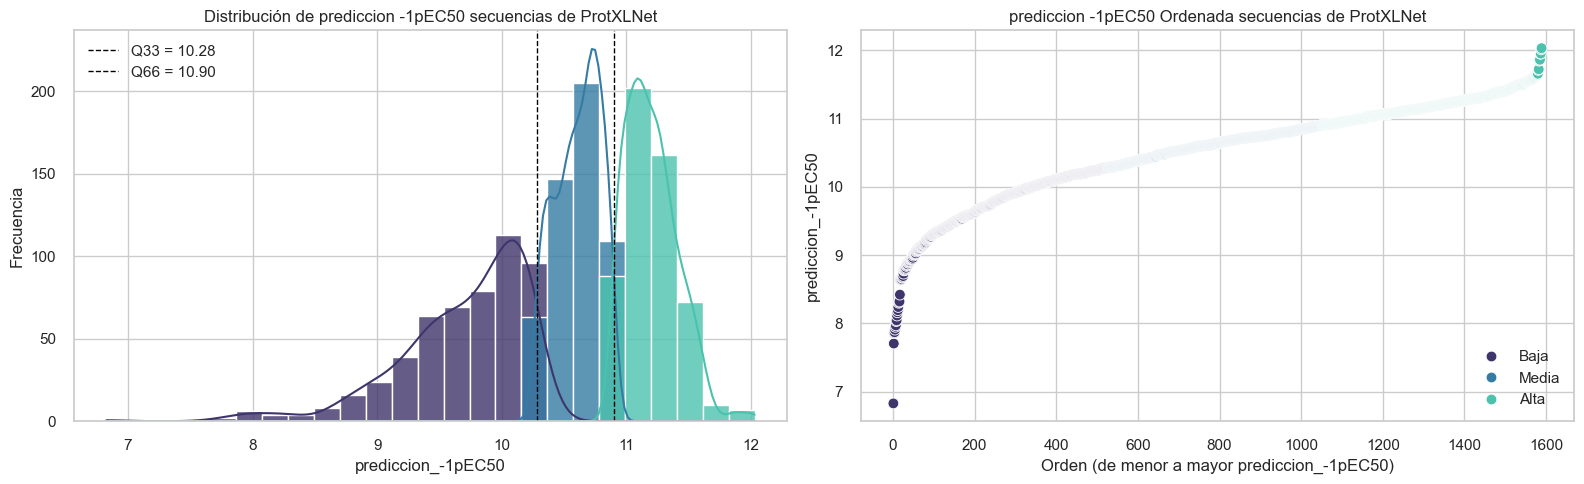


Resumen por categoría:
            n   promedio        min        max
Potencia                                      
Alta      540  11.204675  10.902108  12.031101
Baja      525   9.691591   6.827128  10.279742
Media     524  10.612945  10.280780  10.898850

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
1195  secuencia_1196           12.031101     Alta
1331  secuencia_1332           12.013793     Alta
344    secuencia_345           11.951956     Alta
1405  secuencia_1406           11.949434     Alta
20      secuencia_21           11.861790     Alta
1444  secuencia_1445           11.859737     Alta
514    secuencia_515           11.847478     Alta
508    secuencia_509           11.722294     Alta
755    secuencia_756           11.712342     Alta
781    secuencia_782           11.656545     Alta
859    secuencia_860           11.652848     Alta
1574  secuencia_1575           11.647014     Alta
1415  secuencia_1416           11.636915     Alta
432    secuencia_433           11.634968     Alta
17      secuencia_18           11.633591     Alta

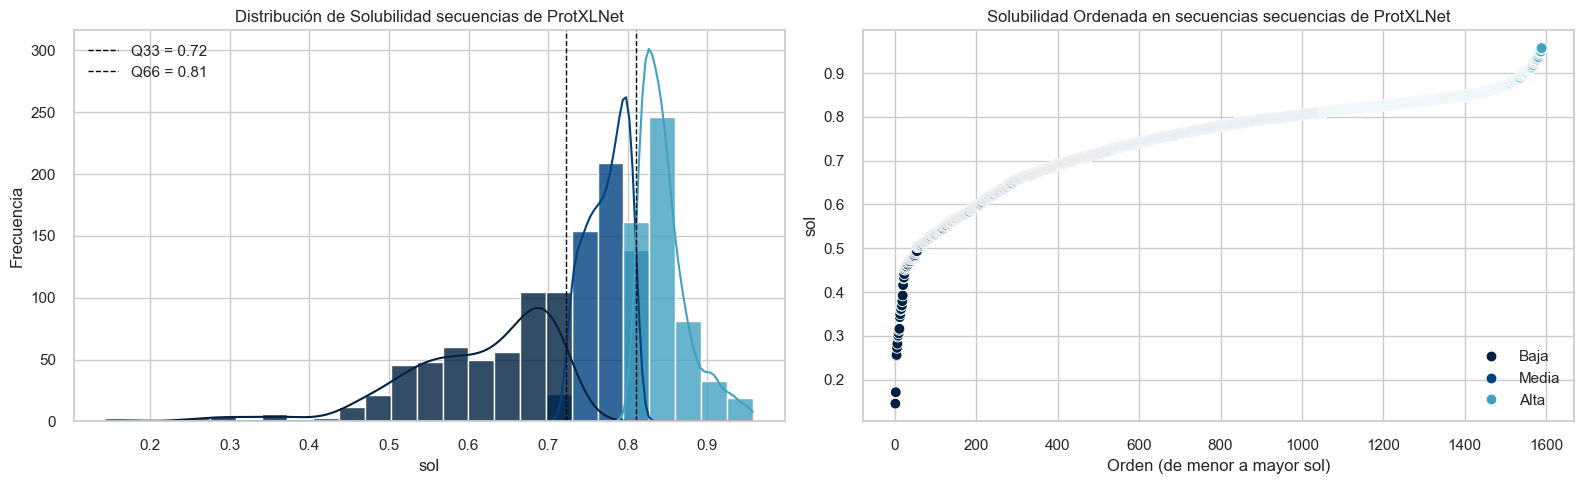


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      540  0.846524  0.811006  0.956944
Baja      525  0.611973  0.145300  0.722346
Media     524  0.773617  0.723253  0.810938

Top 15 registros de categoría "Alta":


ID       sol Potencia
482    secuencia_483  0.956944     Alta
403    secuencia_404  0.954486     Alta
507    secuencia_508  0.949368     Alta
771    secuencia_772  0.948284     Alta
62      secuencia_63  0.947288     Alta
579    secuencia_580  0.947043     Alta
830    secuencia_831  0.944688     Alta
1428  secuencia_1429  0.941610     Alta
674    secuencia_675  0.936698     Alta
1038  secuencia_1039  0.934755     Alta
1504  secuencia_1505  0.933236     Alta
1331  secuencia_1332  0.930686     Alta
348    secuencia_349  0.930435     Alta
162    secuencia_163  0.929512     Alta
1080  secuencia_1081  0.928591     Alta

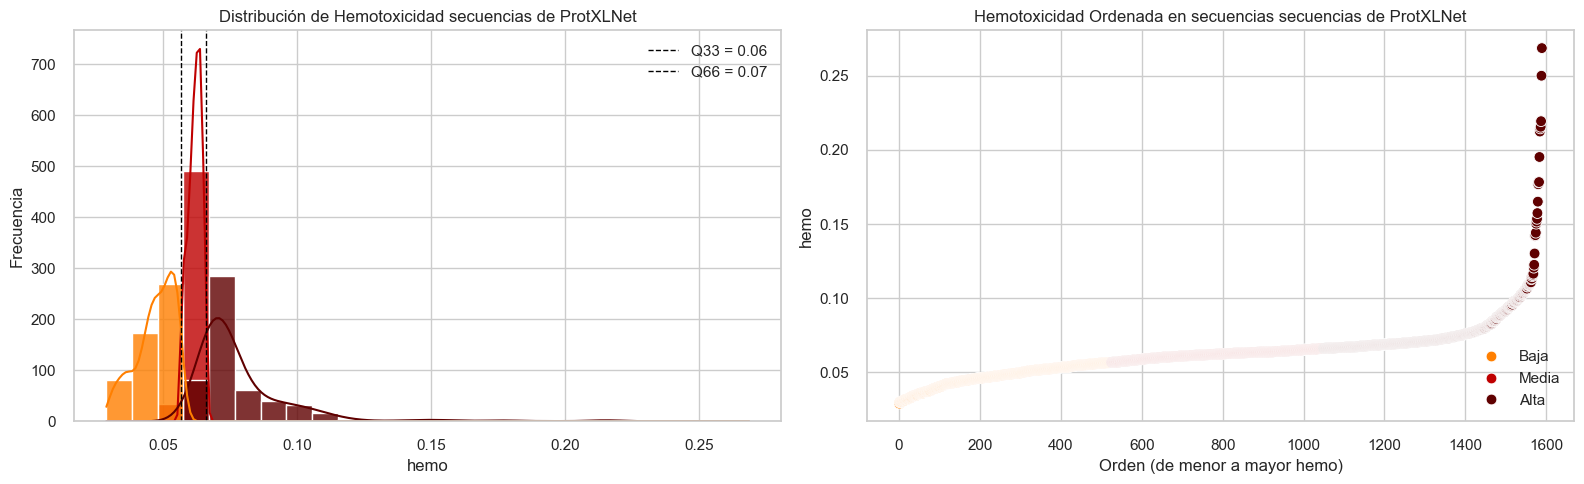


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      540  0.080149  0.066176  0.268602
Baja      525  0.047167  0.028926  0.056655
Media     524  0.061975  0.056768  0.066153

Top 15 registros de categoría "Alta":


ID      hemo Potencia
426    secuencia_427  0.268602     Alta
717    secuencia_718  0.249979     Alta
316    secuencia_317  0.219338     Alta
1009  secuencia_1010  0.215574     Alta
269    secuencia_270  0.214464     Alta
510    secuencia_511  0.212346     Alta
937    secuencia_938  0.195199     Alta
105    secuencia_106  0.178303     Alta
778    secuencia_779  0.178098     Alta
574    secuencia_575  0.176810     Alta
734    secuencia_735  0.165081     Alta
120    secuencia_121  0.157380     Alta
1380  secuencia_1381  0.153501     Alta
815    secuencia_816  0.151644     Alta
162    secuencia_163  0.150224     Alta

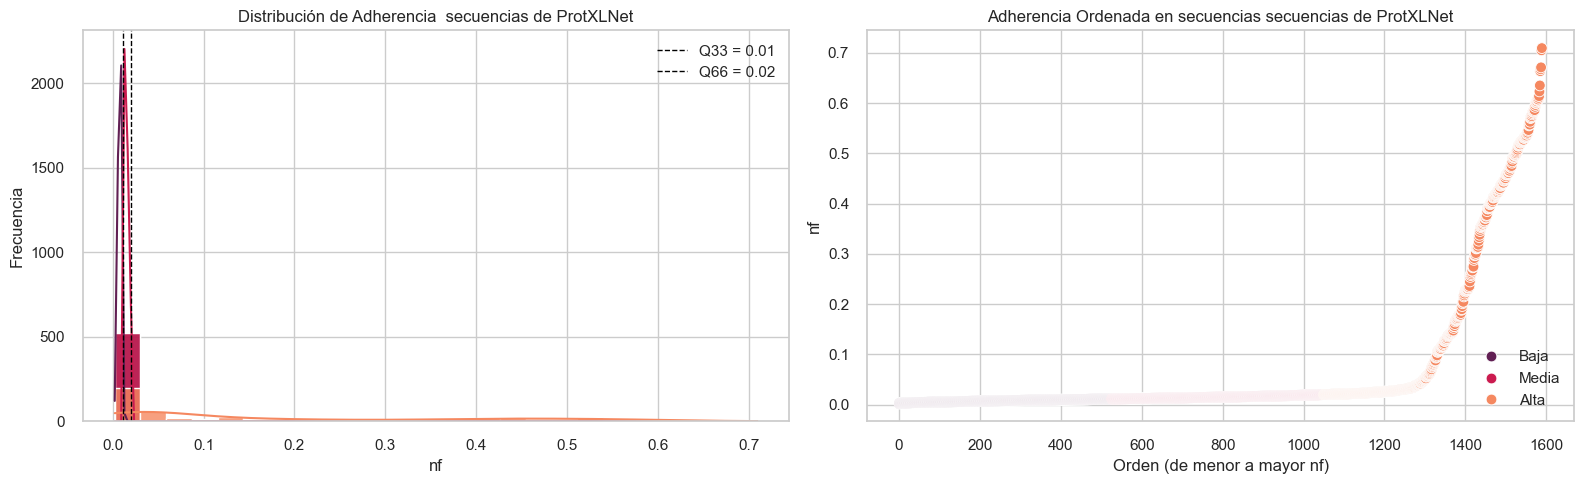


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      540  0.191590  0.020146  0.709187
Baja      525  0.007941  0.002265  0.011552
Media     524  0.015292  0.011557  0.020142

Top 15 registros de categoría "Alta":


ID        nf Potencia
793    secuencia_794  0.709187     Alta
1254  secuencia_1255  0.704811     Alta
740    secuencia_741  0.670887     Alta
1194  secuencia_1195  0.667108     Alta
1316  secuencia_1317  0.663376     Alta
101    secuencia_102  0.634929     Alta
471    secuencia_472  0.623050     Alta
734    secuencia_735  0.613616     Alta
87      secuencia_88  0.610250     Alta
1057  secuencia_1058  0.607038     Alta
1428  secuencia_1429  0.606461     Alta
589    secuencia_590  0.606002     Alta
1527  secuencia_1528  0.603414     Alta
866    secuencia_867  0.602464     Alta
206    secuencia_207  0.600395     Alta

In [47]:
# Generación de gráficos de las nuevas secuencias generadas con ProtXLNet
%matplotlib inline 

clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protxlnet,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de prediccion -1pEC50 secuencias de ProtXLNet',
    titulo_ordenado='prediccion -1pEC50 Ordenada secuencias de ProtXLNet')    
    
clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protxlnet,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='ocean',
    titulo_distribucion='Distribución de Solubilidad secuencias de ProtXLNet',
    titulo_ordenado='Solubilidad Ordenada en secuencias secuencias de ProtXLNet'
)    

clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protxlnet,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemotoxicidad secuencias de ProtXLNet',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias secuencias de ProtXLNet'
)

clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protxlnet,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia  secuencias de ProtXLNet',
    titulo_ordenado='Adherencia Ordenada en secuencias secuencias de ProtXLNet'
)

### ProXLNet entrenado con peptidos GLP-1 sobre 8 capas

In [48]:
from datetime import datetime
# Generar timestamp en formato AñoMesDía_HoraMinutoSegundo
File_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')


In [49]:
variants = generate_with_protxlnet_pipeline(
    ruta_modelo_protxlnet = directorio_modelos / "prot_xlnet",
    prompt_sequences=prompt_sequences,
    num_variants_per_seq=30,
    num_return_sequences=5,
    max_length=longitud_maxima,
    min_length=longitud_minima,
    top_k=50,
    repetition_penalty=1.0,
)
df_secuencias_protxlnet_8 = pd.DataFrame(variants, columns=["sequence"])


Usando dispositivo: cuda
Cargando pipeline de generación...
Pipeline cargado.
Preparando las secuencias iniciales...


  0%|          | 0/54 [00:00<?, ?it/s]

Generando 1596 variantes (el pipeline manejará los lotes)...
Procesando salidas...


Procesando:   0%|          | 0/1596 [00:00<?, ?it/s]


Generación completada. Se obtuvieron 1596 variantes únicas.


In [53]:
# Limpiar valors no validos
allowed_chars = "ACDEFGHIKLMNPQRSTVWY"
pattern_to_remove = f"[^{allowed_chars}]"

df_secuencias_protxlnet_8['sequence'] = df_secuencias_protxlnet_8['sequence'].str.replace(pattern_to_remove, '', regex=True)
                        
df_secuencias_protxlnet_8['ID'] = [f"secuencia_{idx}" for idx in range(1, len(df_secuencias_protxlnet_8) + 1)]
df_secuencias_protxlnet_8 = df_secuencias_protxlnet_8[['ID', 'sequence']]
df_secuencias_protxlnet_8.head(10)

ID                                   sequence
0   secuencia_1  YAEGTFTSDYSIYLDIKAAQEFVNWTLAGGPSSGAPPPSPT
1   secuencia_2  HLQGTFTSDYSKYLDSRAAACFVQWLLNGGPSSGAPPCGGA
2   secuencia_3   HSQGTFTSEYSKYLDSERARDFVQWLVANGTTDYSKYLDS
3   secuencia_4    HSQGTFTSDYSKYLDSERARDPVQWLISEARDPVQWLIS
4   secuencia_5    HAEGTFTGDVSSYLEGQAAKEFIAWVKGRPEIIAWMEAK
5   secuencia_6    HSQGTFTSDYSKYLDSRRASEFVKWLIAESQEEEEQQQQ
6   secuencia_7  YSEGTFTSDYSKLKEEEANRLFIEWLLAGGPSSGAPRPSGT
7   secuencia_8   HSQGTFTSDYSKFLDSERAREFVQWLVAGGHVQHHQQQQQ
8   secuencia_9                HAEGTFPSDVSSYLEGQGEQTERTASE
9  secuencia_10   HSQGTFTSEYSKYLDSERARDFVQWEVAGGLSEYAKYLDN

In [54]:
# Cálculo de descriptores y actividad biológica predicha para las nuevas secuencias generadas con ProtXLNET

df_secuencias_protxlnet_8 = calcular_descriptores_ifeature(
        directorio_temporal=directorio_temporal,
        dataframe=df_secuencias_protxlnet_8,
        sequence_col='sequence',
        id_col='ID',
        descriptores=descriptores,
        ifeatures_settings_json=ifeatures_settings_json
    )
    
# Calculo de pEC50 sobre los datos de alpha fold y uniprot
df_secuencias_protxlnet_8 = predict_model(modelo_pycaret, data=df_secuencias_protxlnet_8)
df_secuencias_protxlnet_8.rename(columns={'prediction_label': 'prediccion_-1pEC50'}, inplace=True)
# Predicciones con PeptideBert para el conjunto obtenido de la base de datos de Aphafold
df_secuencias_protxlnet_8 = predict_peptidebert(
    directorio_modelos_peptidebert,
    df_secuencias_protxlnet_8,
    sequence_col='sequence',  # Le dices qué columna usar
    feats=['hemo', 'sol', 'nf']
)

Success! DataFrame has been saved to 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_233121.fasta'.
Inspecting file: d:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_233121.fasta...
  - OK! File is structurally valid. Found 1596 records.
'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_233121.fasta' es válido. Se encontraron 1596 registros.
Iniciando cálculo de 14 descriptores...


calculando descriptores:   0%|          | 0/14 [00:00<?, ?it/s]

File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
File imported successfully.
Cálculo de descriptores finalizado.
Descriptores unidos al DataFrame. Forma final: (1596, 1292)
Archivo temporal 'd:\source\Proyecto Integrador\glp-1_drug_discovery\temp\ifeature_input_20251026_233121.fasta' eliminado.
Usando dispositivo: cuda
Procesando caracteristica: hemo


  0%|          | 0/1596 [00:00<?, ?it/s]

Procesando caracteristica: sol


  0%|          | 0/1596 [00:00<?, ?it/s]

Procesando caracteristica: nf


  0%|          | 0/1596 [00:00<?, ?it/s]

In [55]:
# guardar en un archivo CSV las nuevas secuencias generadas

# Guardar df_secuencias_nuevas en CSV con timestamp

nombre_archivo = f"secuencias_nuevas_protxlnet_8{File_timestamp}"
nombre_archivo_csv = f"{nombre_archivo}.csv"

# Guardar el DataFrame en CSV
ruta_salida_secuencias_nuevas = Path(directorio_nuevas_secuencias /nombre_archivo_csv)

df_secuencias_protxlnet_8.to_csv(ruta_salida_secuencias_nuevas, index=False)
print(f"Archivo guardado: {ruta_salida_secuencias_nuevas}")

Archivo guardado: d:\source\Proyecto Integrador\glp-1_drug_discovery\data\processed\Actividad_5\secuencias_nuevas\secuencias_nuevas_protxlnet_820251026_232714.csv


### Resultados de la generación de nuevas secuencias con ProXLNET 

In [56]:
#Top  de secuencias generadas por propiedades deseadas 
df_secuencias_protxlnet_8.sort_values(by=['prediccion_-1pEC50','sol','hemo','nf'], ascending=[False, False, True, True], inplace=True)
df_secuencias_protxlnet_8[["ID","sequence","sol","hemo", "nf","prediccion_-1pEC50"]].head()

ID                                   sequence       sol  \
1566  secuencia_1567                       YSEGTFTGDLGVDVGMGGNV  0.829813   
1493  secuencia_1494          HSQGTFTSDYSRYLDSRRASEFVDYGSRAGLGV  0.732158   
797    secuencia_798  YSEGTFTSDYSKLLERQAIDEFVNWLLKGGPSLGAPPPSGA  0.641930   
1342  secuencia_1343  YSEGTFTSDYSKLLEEAAVRDFIEWLLAGGPSSGAPPPSAA  0.568676   
1236  secuencia_1237  YSEGTFTSDYSKLLEGEAVRDFIEWLLAGGPSSGAPPPSGG  0.723984   

          hemo        nf  prediccion_-1pEC50  
1566  0.080669  0.132715           11.929176  
1493  0.059699  0.023636           11.819596  
797   0.070540  0.009047           11.806339  
1342  0.070886  0.008207           11.748090  
1236  0.071589  0.013539           11.562530

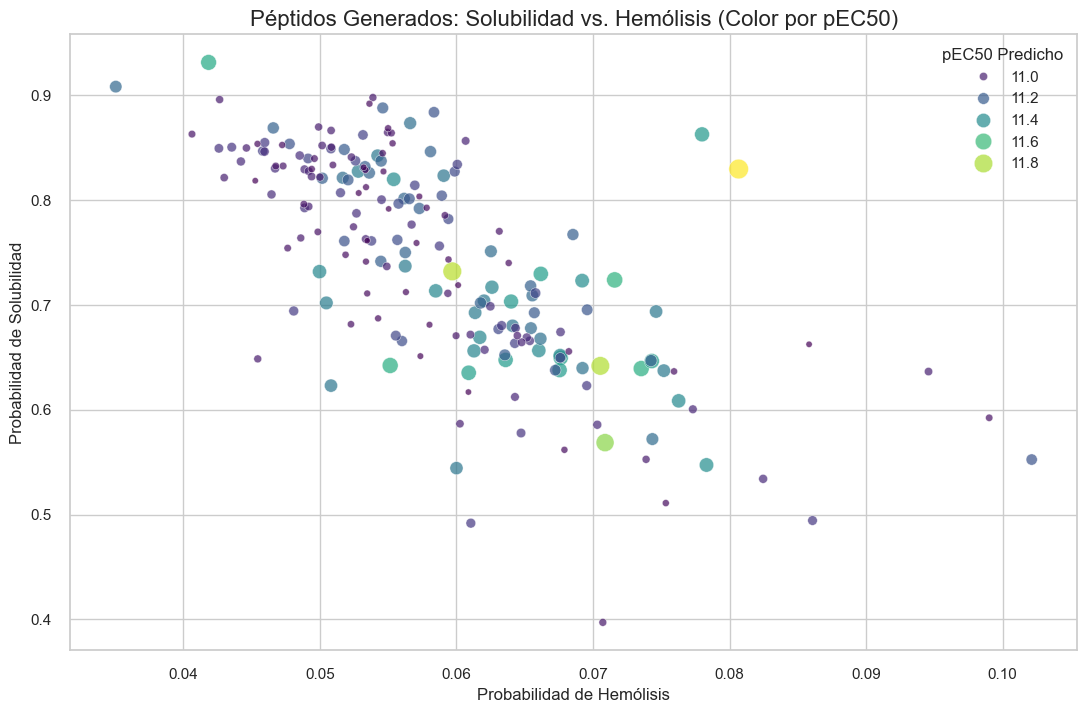

In [61]:
## Visualización de las propiedades predichas: Hemólisis vs Solubilidad coloreado por pEC50

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Crear el gráfico de dispersión
plt.figure(figsize=(13, 8))
scatter = sns.scatterplot(
    data=df_secuencias_protxlnet_8.head(200), # Mostrar solo las 200 secuencias con mayor pEC50
    x='hemo',
    y='sol',
    hue='prediccion_-1pEC50',
    palette='viridis', # Usamos un mapa de color "viridis" donde los colores más claros indican valores más altos
    size='prediccion_-1pEC50', # El tamaño del punto también representará el pEC50
    sizes=(20, 200),
    alpha=0.7,
    edgecolor='w'
)

# Añadir títulos y etiquetas
plt.title('Péptidos Generados: Solubilidad vs. Hemólisis (Color por pEC50)', fontsize=16)
plt.xlabel('Probabilidad de Hemólisis', fontsize=12)
plt.ylabel('Probabilidad de Solubilidad', fontsize=12)
plt.legend(title='pEC50 Predicho')
plt.grid(True)

# Mostrar el gráfico
plt.show()

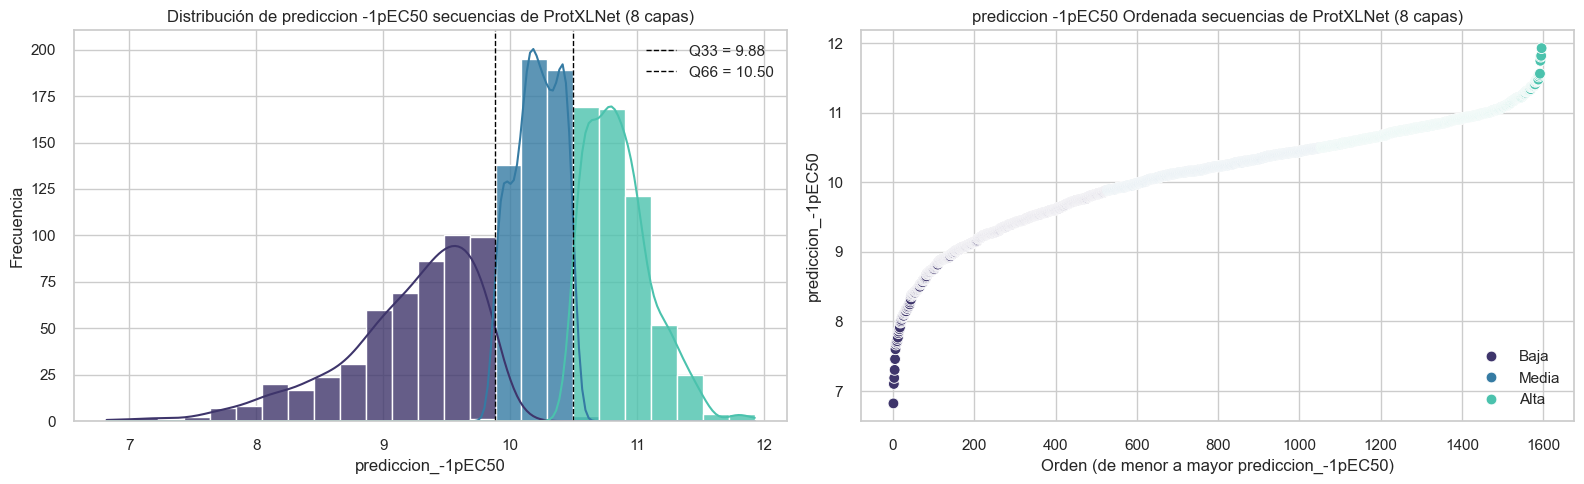


Resumen por categoría:
            n   promedio        min        max
Potencia                                      
Alta      543  10.860838  10.500519  11.929176
Baja      527   9.198240   6.821622   9.881836
Media     526  10.214159   9.885194  10.499897

Top 15 registros de categoría "Alta":


ID  prediccion_-1pEC50 Potencia
1566  secuencia_1567           11.929176     Alta
1493  secuencia_1494           11.819596     Alta
797    secuencia_798           11.806339     Alta
1342  secuencia_1343           11.748090     Alta
1236  secuencia_1237           11.562530     Alta
418    secuencia_419           11.545896     Alta
693    secuencia_694           11.545470     Alta
204    secuencia_205           11.522425     Alta
415    secuencia_416           11.477854     Alta
1419  secuencia_1420           11.473189     Alta
763    secuencia_764           11.472687     Alta
1006  secuencia_1007           11.469538     Alta
202    secuencia_203           11.466687     Alta
1268  secuencia_1269           11.466099     Alta
1259  secuencia_1260           11.453174     Alta

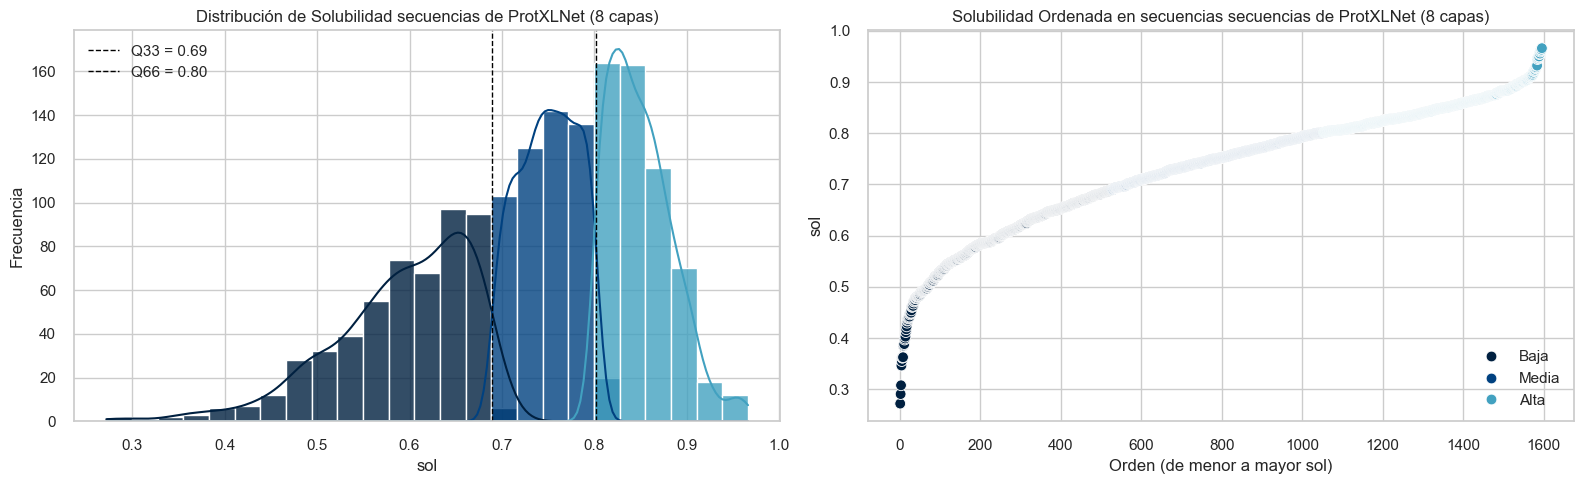


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      543  0.849891  0.801651  0.966094
Baja      527  0.591882  0.272085  0.689468
Media     526  0.749760  0.689913  0.801631

Top 15 registros de categoría "Alta":


ID       sol Potencia
1541  secuencia_1542  0.966094     Alta
807    secuencia_808  0.963340     Alta
931    secuencia_932  0.963126     Alta
751    secuencia_752  0.961297     Alta
712    secuencia_713  0.959445     Alta
909    secuencia_910  0.955671     Alta
1354  secuencia_1355  0.954371     Alta
753    secuencia_754  0.950011     Alta
1469  secuencia_1470  0.949660     Alta
583    secuencia_584  0.947872     Alta
1084  secuencia_1085  0.946829     Alta
1590  secuencia_1591  0.944816     Alta
460    secuencia_461  0.932148     Alta
204    secuencia_205  0.931574     Alta
400    secuencia_401  0.928987     Alta

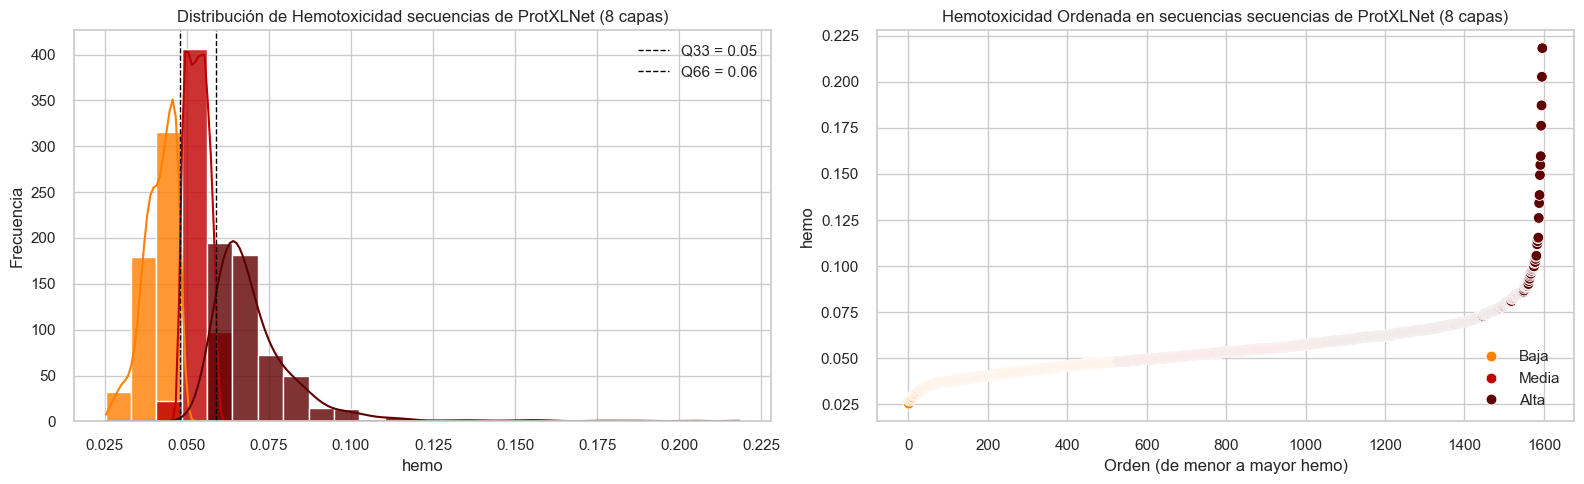


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      543  0.071333  0.058879  0.218326
Baja      527  0.041537  0.025291  0.048030
Media     526  0.053089  0.048039  0.058861

Top 15 registros de categoría "Alta":


ID      hemo Potencia
1314  secuencia_1315  0.218326     Alta
1146  secuencia_1147  0.202803     Alta
1046  secuencia_1047  0.187254     Alta
121    secuencia_122  0.176232     Alta
1015  secuencia_1016  0.159675     Alta
1308  secuencia_1309  0.154920     Alta
37      secuencia_38  0.149417     Alta
1094  secuencia_1095  0.138599     Alta
844    secuencia_845  0.134225     Alta
903    secuencia_904  0.126123     Alta
1463  secuencia_1464  0.115440     Alta
1392  secuencia_1393  0.115132     Alta
457    secuencia_458  0.113505     Alta
993    secuencia_994  0.111841     Alta
1135  secuencia_1136  0.111722     Alta

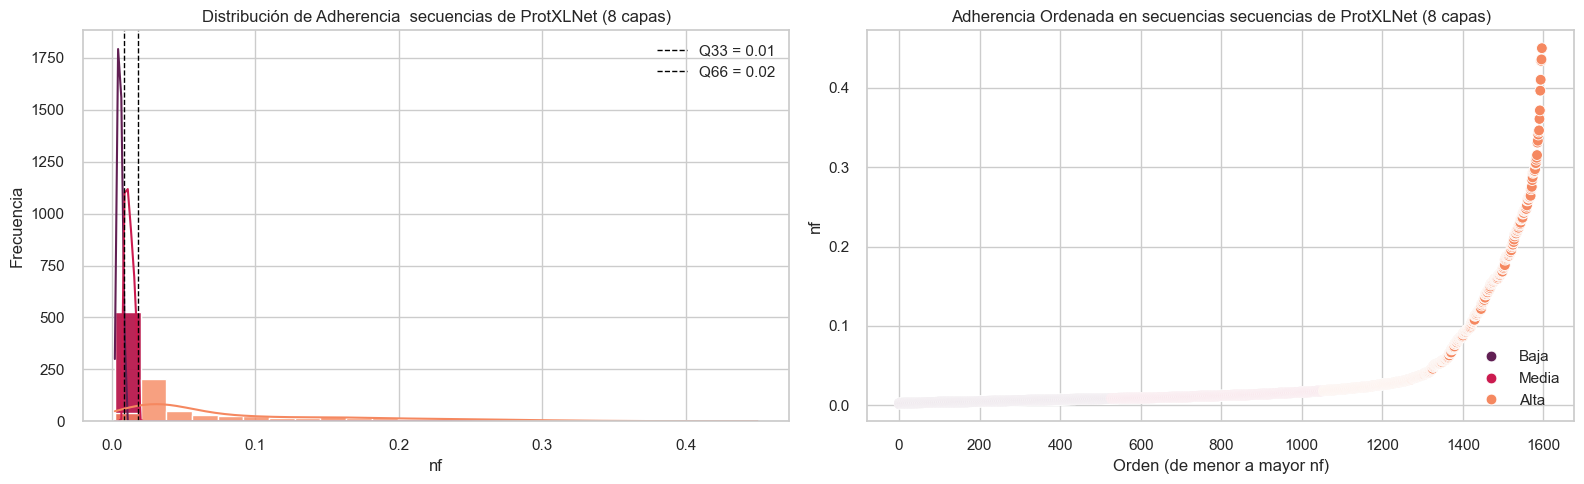


Resumen por categoría:
            n  promedio       min       max
Potencia                                   
Alta      543  0.091154  0.018399  0.449974
Baja      527  0.005594  0.002085  0.008550
Media     526  0.012374  0.008562  0.018389

Top 15 registros de categoría "Alta":


ID        nf Potencia
1162  secuencia_1163  0.449974     Alta
513    secuencia_514  0.435822     Alta
104    secuencia_105  0.434020     Alta
1155  secuencia_1156  0.410212     Alta
327    secuencia_328  0.396464     Alta
1460  secuencia_1461  0.371596     Alta
986    secuencia_987  0.360792     Alta
522    secuencia_523  0.346386     Alta
1541  secuencia_1542  0.344852     Alta
1594  secuencia_1595  0.341142     Alta
647    secuencia_648  0.333393     Alta
49      secuencia_50  0.331013     Alta
488    secuencia_489  0.315281     Alta
1045  secuencia_1046  0.311907     Alta
644    secuencia_645  0.309320     Alta

In [57]:
# Generación de gráficos de las nuevas secuencias generadas con ProtXLNet
%matplotlib inline 

clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protxlnet_8,   columna_valor='prediccion_-1pEC50', 
    columna_id='ID', top_n=15,palette='mako',
    titulo_distribucion='Distribución de prediccion -1pEC50 secuencias de ProtXLNet (8 capas)',
    titulo_ordenado='prediccion -1pEC50 Ordenada secuencias de ProtXLNet (8 capas)')    
    
clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protxlnet_8,   columna_valor='sol', 
    columna_id='ID', top_n=15,palette='ocean',
    titulo_distribucion='Distribución de Solubilidad secuencias de ProtXLNet (8 capas)',
    titulo_ordenado='Solubilidad Ordenada en secuencias secuencias de ProtXLNet (8 capas)'
)    

clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protxlnet_8,   columna_valor='hemo', 
    columna_id='ID', top_n=15,palette='gist_heat_r',
    titulo_distribucion='Distribución de Hemotoxicidad secuencias de ProtXLNet (8 capas)',
    titulo_ordenado='Hemotoxicidad Ordenada en secuencias secuencias de ProtXLNet (8 capas)'
)

clasificar_y_graficar_cuantiles(
    df_input=df_secuencias_protxlnet_8,   columna_valor='nf', 
    columna_id='ID', top_n=15, palette='rocket',
    titulo_distribucion='Distribución de Adherencia  secuencias de ProtXLNet (8 capas)',
    titulo_ordenado='Adherencia Ordenada en secuencias secuencias de ProtXLNet (8 capas)'
)

### Análisis de resultados con de ProXLNet

Los resultados de ProXLNet muestran mejores características de actividad biológica, esto se debe a que tiende a completar las secuencias repitiendo aminoácidos más que intentar generar secuencias nuevas, aunque las secuencias que se obtienen repiten aminoácidos y tienen menor diversidad y por lo tanto hay menos secuencias únicas, el modelo predictivo indica mejoras en la actividad eP50 al actuar de forma conservadora con el prompt.

El modelo al que se entreno descongelando 10 capas tuvo mejor desempeño aunque marginal respecto a modelo que se entreno descongelando 8 capas


# Comparativa de resultados

En el siguiente gráfico se muestran los datos correspondientes a los 3 modelos de lenguaje utilizados para la generación de nuevas secuencias peptídicas: ProtGPT2, ProXLNet con 10 capas descongeladas y ProXLNet con 8 capas descongeladas. Cada punto en el gráfico representa una secuencia generada, y el color indica la predicción de actividad biológica (-1pEC50) obtenida mediante el modelo predictivo entrenado previamente.

Se aprecia que ProXLNet obtuvo mejores resultados en general

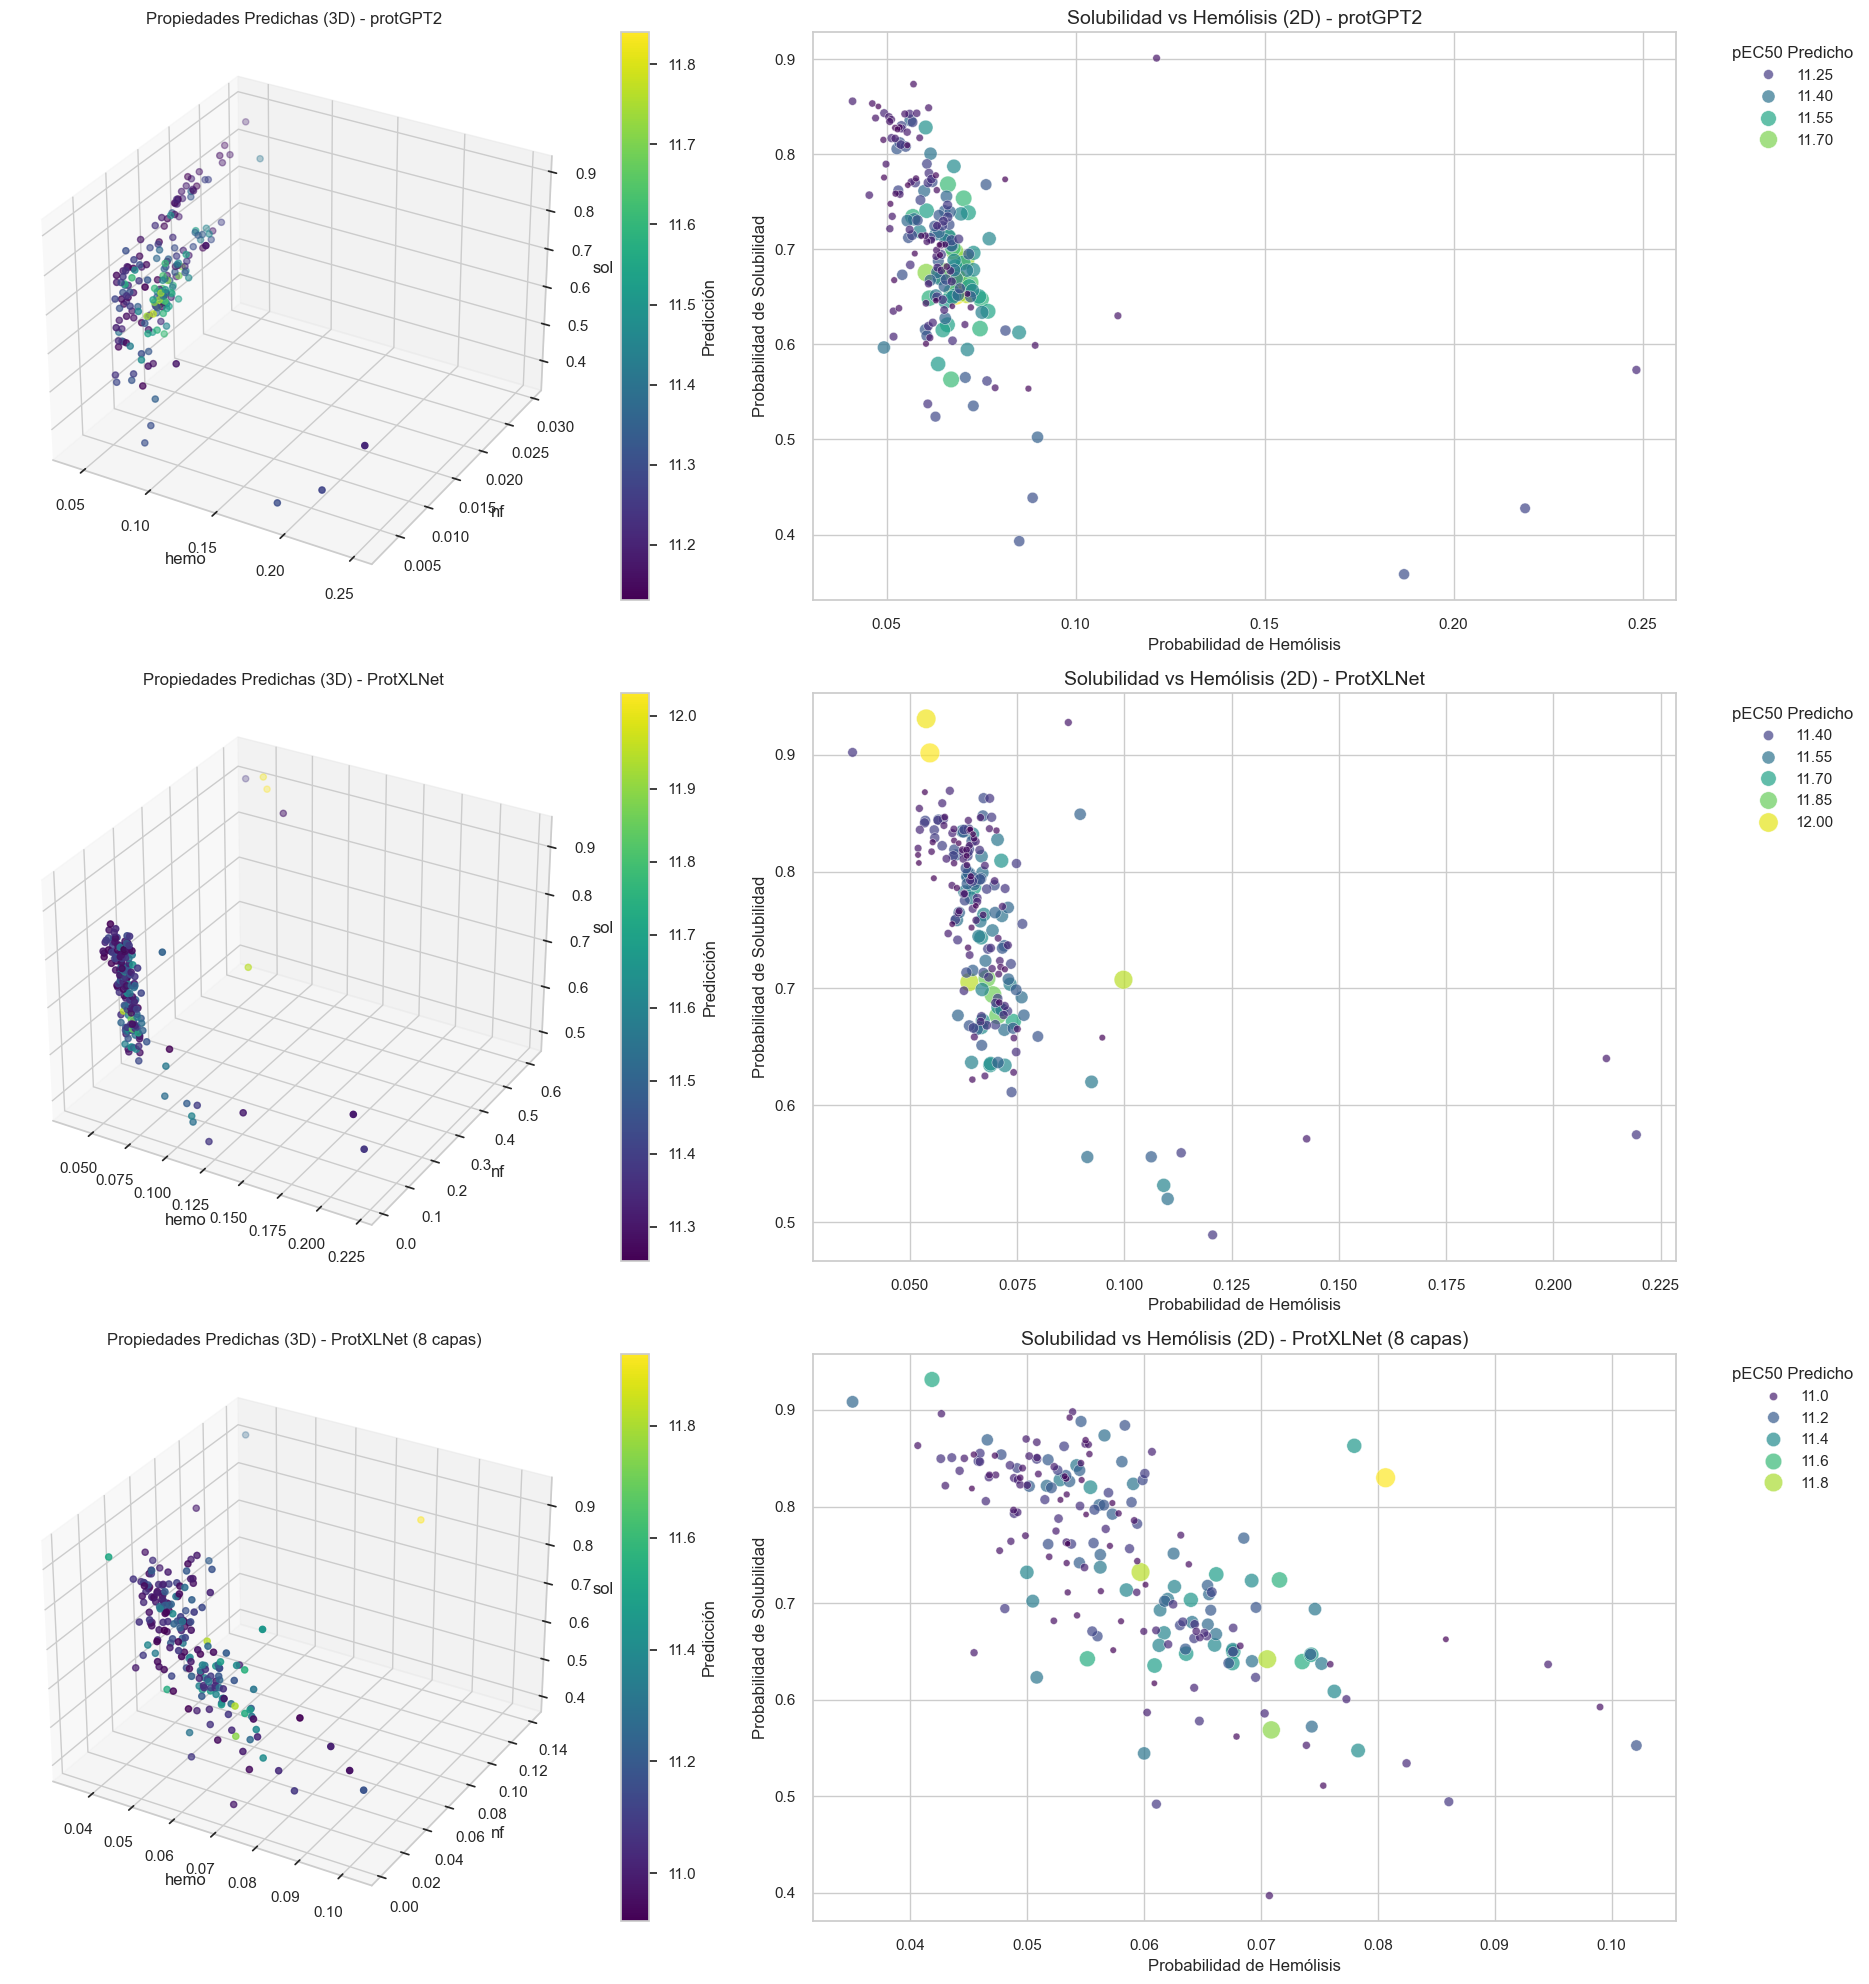

In [85]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Lista de dataframes y títulos para iterar (ajusta nombres)
datasets = [
    (df_secuencias_protGPT2, "protGPT2"),
    (df_secuencias_protxlnet, "ProtXLNet"),
    (df_secuencias_protxlnet_8, "ProtXLNet (8 capas)")
]

# Crear figura con 3 filas y 2 columnas

fig = plt.figure(figsize=(20, 20))  # Ajustar tamaño si hace falta

for i, (df, titulo) in enumerate(datasets, start=1):
    # Subplot 3D
    ax3d = fig.add_subplot(len(datasets), 2, (i - 1) * 2 + 1, projection='3d')
    plot_pca_3d(
        df.head(200),
        pc_x='hemo',
        pc_y='nf',
        pc_z='sol',
        color_by='prediccion_-1pEC50',
        label='Predicción',
        ax=ax3d,
        cmap='viridis',
        title=f'Propiedades Predichas (3D) - {titulo}',
    )

    # Subplot 2D
    ax2d = fig.add_subplot(len(datasets), 2, (i - 1) * 2 + 2)
    scatter = sns.scatterplot(
        data=df.head(200),
        x='hemo',
        y='sol',
        hue='prediccion_-1pEC50',
        palette='viridis',
        size='prediccion_-1pEC50',
        sizes=(20, 200),
        alpha=0.7,
        edgecolor='w',
        ax=ax2d
    )
    
    ax2d.set_title(f'Solubilidad vs Hemólisis (2D) - {titulo}', fontsize=14)
    ax2d.set_xlabel('Probabilidad de Hemólisis', fontsize=12)
    ax2d.set_ylabel('Probabilidad de Solubilidad', fontsize=12)
    ax2d.grid(True)
    ax2d.legend(title='pEC50 Predicho', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


# Conclusión

El presente trabajo logró su objetivo principal al implementar un pipeline de inteligencia artificial para la generación y evaluación *in silico* de nuevas secuencias peptídicas. A pesar de los desafíos metodológicos, se identificaron candidatos con una alta actividad agonista de GLP-1 predicha, algunos de los cuales mostraron un potencial teórico superior al péptido humano de referencia, lo que sugiere su viabilidad como base para el desarrollo de futuros fármacos.

Sin embargo, se observa que los modelos de lenguaje generativos utilizados (ProtXLNet y ProtGPT2) se encuentran aún en una etapa "experimental" para esta tarea específica. En particular, ProtXLNet demostró ser inmaduro, ya que tendió a repetir secuencias de aminoácidos, generando resultados con baja diversidad o incluso secuencias inválidas, a pesar del entrenamiento con un conjunto diverso de secuencias GLP-1. No obstante, generó secuencias con mejores características que ProtGPT2. Por otro lado, ProtGPT2 ofreció un desempeño relativamente superior al generar secuencias más variadas y estructuralmente válidas sin repeticiones excesivas, pero la eficacia biológica predicha fue en general, menor, posiblemente debido a su tendencia a generar secuencias completamente nuevas en lugar de modificar gradualmente una secuencia inicial, como lo hace ProtXLNet. ProtGPT2 produjo secuencias más realistas y cercanas a las biológicas conocidas, pero no necesariamente más efectivas.

A este respecto, ProtGPT2 generó secuencias con las siguientes características de actividad biológica pEC50:

| Potencia | n    | Promedio   | Min        | Max        |
|----------|------|------------|------------|------------|
| Alta     | 1737 | 10.838746  | 10.518702  | 11.840127  |
| Baja     | 1686 | 9.563515   | 6.107145   | 10.045160  |
| Media    | 1686 | 10.291403  | 10.045923  | 10.518688  |

Mientras que ProtXLNet obtuvo las siguientes características:

| Potencia | n    | Promedio   | Min        | Max        |
|----------|------|------------|------------|------------|
| Alta     | 540  | 11.204675  | 10.902108  | 12.031101  |
| Baja     | 525  | 9.691591   | 6.827128   | 10.279742  |
| Media    | 524  | 10.612945  | 10.280780  | 10.898850  |

Cabe destacar que ProtXLNet también presentó problemas de desempeño computacional: a pesar de ser un modelo más pequeño (30 capas frente a las 36 de ProtGPT2), requirió significativamente más tiempo para generar secuencias.

Ante las limitaciones observadas en cuanto a calidad, control y optimización de las secuencias generadas, se considera que la incorporación de algoritmos genéticos representa una alternativa metodológica más prometedora para trabajos futuros. Estos permitirían una exploración más dirigida, combinando secuencias con las mejores características para maximizar la actividad biológica, superando así la naturaleza menos controlada de los modelos de lenguaje. Otra línea viable sería la adopción de modelos de lenguaje más recientes, como aquellos basados en arquitecturas LLaMA o Gemma, aunque actualmente no existen referencias aplicadas al diseño de proteínas con dichos modelos.

El análisis de los resultados obtenidos mediante el modelo predictivo entrenado con péptidos de actividad biológica conocida también muestra la posibilidad de emplear secuencias derivadas de especies existentes para sintetizar compuestos viables, siguiendo un enfoque similar al utilizado en el desarrollo de la liraglutida, derivada del GLP-1 de otra especie.

A este respecto, el modelo predictivo obtuvo las siguientes métricas:

| Fold | MAE     | MSE     | RMSE    | R2      | RMSLE   | MAPE    |
|------|---------|---------|---------|---------|---------|---------|
| **Mean** | **0.6334** | **0.7794** | **0.8146** | **0.6437** | **0.0779** | **0.0689** |
| **Std**  | **0.2570** | **0.7524** | **0.3402** | **0.3101** | **0.0337** | **0.0319** |

Si bien el modelo presenta métricas razonables considerando la limitada cantidad de datos disponibles, se decidió no continuar con su entrenamiento debido a la escasez de información adicional para mejorar las predicciones y a señales visibles de sobreajuste. Este modelo consiste en un *blending* de tres algoritmos: **CatBoost Regressor**, **ExtraTreesRegressor** y **HuberRegressor**, y en general tiende a subestimar la actividad biológica, como se aprecia en los gráficos correspondientes a la distribución de los valores predichos de -1pEC50.

En general, este trabajo muestra que es posible establecer un pipeline basado en inteligencia artificial para la investigación de compuestos análogos al GLP-1 y, potencialmente, otros péptidos de interés, siempre que se cuente con datos suficientes que permitan entrenar modelos predictivos robustos.


## Referencias
* Elnaggar, A., Heinzinger, M., Dallago, C., Rehawi, G., Wang, Y., Jones, L., Gibbs, T., Feher, T., Angerer, C., Steinegger, M., Bhowmik, D., & Rost, B. (2021). ProtTrans: Toward Understanding the Language of Life Through Self-Supervised Learning. IEEE Transactions On Pattern Analysis And Machine Intelligence, 44(10), 7112-7127. https://doi.org/10.1109/tpami.2021.3095381

Ferruz, N., Schmidt, S., & Höcker, B. (2022). ProtGPT2 is a deep unsupervised language model for protein design. Nature Communications, 13(1). https://doi.org/10.1038/s41467-022-32007-7

* Grasso, G., Musso, N., & Rizzarelli, E. (2021). Toxicological assessment of peptide-based therapeutics: The role of hemolysis studies. Toxins, 13(4), 278. https://doi.org/10.3390/toxins13040278


* White, A. D., Nowinski, A. K., & Keefe, A. J. (2019). Non-fouling surfaces: Design and applications. Annual Review of Chemical and Biomolecular Engineering, 10, 17–39. https://doi.org/10.1146/annurev-chembioeng-060718-030022

* Zhou, X., Chen, Y., & Liu, Y. (2023). AI-driven drug discovery: Integrating computational models with biological data. Nature Reviews Drug Discovery, 22(4), 271–289. https://doi.org/10.1038/s41573-023-00231-7

* Puszkarska, A. M., Taddese, B., Revell, J., Davies, G., Field, J., Hornigold, D. C., Buchanan, A., Vaughan, T. J., & Colwell, L. J. (2024). Machine learning designs new GCGR/GLP-1R dual agonists with enhanced biological potency. Nature Chemistry, 16(9), 1436-1444. https://doi.org/10.1038/s41557-024-01532-x

* Chou, K. (2001). Prediction of protein cellular attributes using pseudo‐amino acid composition. Proteins Structure Function And Bioinformatics, 43(3), 246-255. https://doi.org/10.1002/prot.1035

* Guntuboina, C., Das, A., Mollaei, P., Kim, S., & Farimani, A. B. (2023). PeptideBERT: A Language Model Based on Transformers for Peptide Property Prediction. The Journal Of Physical Chemistry Letters, 14(46), 10427-10434. https://doi.org/10.1021/acs.jpclett.3c02398